# 数据获取

### Cell 0 — 安装依赖

In [ ]:
!pip -q install aiohttp nest_asyncio tqdm ujson python-dateutil

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 824.0 kB/s eta 0:00:00


### Cell 1 — 挂载 Drive & 固定批次目录（不会因重跑改时间戳）

In [ ]:
from google.colab import drive
from pathlib import Path
import datetime as dt
from dateutil.tz import tzlocal

drive.mount('/content/drive', force_remount=True)

ROOT_DIR = Path("/content/drive/MyDrive/6893")
RUN_FILE = ROOT_DIR / "raw" / "run.id"

if RUN_FILE.exists():
    TIMESTAMP = RUN_FILE.read_text().strip()
else:
    TIMESTAMP = dt.datetime.now(tzlocal()).strftime("%Y%m%d_%H%M")
    RUN_FILE.parent.mkdir(parents=True, exist_ok=True)
    RUN_FILE.write_text(TIMESTAMP)

RAW_DIR  = ROOT_DIR / "raw" / TIMESTAMP
LOG_DIR  = RAW_DIR / "_logs"
for p in [ROOT_DIR, RAW_DIR, LOG_DIR]:
    p.mkdir(parents=True, exist_ok=True)

print("Data root:", ROOT_DIR)
print("Pinned batch dir:", RAW_DIR)

Mounted at /content/drive
Data root: /content/drive/MyDrive/6893
Pinned batch dir: /content/drive/MyDrive/6893/raw/20251112_0011


### 检查重复

In [ ]:
from pathlib import Path

# ===============================
# 你这次要抓的 uus
# ===============================
UP_UIDS = [
352091301,
479893558,
23408614,
546195,
501005668,
261485584,
544142239,
300634025,
3493092783032940,
1185017133,
75,
38598226,
4549624,
168598,
517327498,
18343098,
13164144,
39627524,
232472043,
494293576,
23920239,
1750535730,
3546929849961165,
383433896,
679237565
]

# 你统一的 raw 文件夹
RAW_ROOT = Path("/content/drive/MyDrive/6893/raw")

def list_all_existing_uids(root):
    """在 raw 目录下递归查找已有的 uid 文件夹"""
    existing = set()

    for batch_dir in root.iterdir():
        if not batch_dir.is_dir():
            continue

        for uid_dir in batch_dir.iterdir():
            if uid_dir.is_dir():
                # 只保留纯数字的文件夹名
                if uid_dir.name.isdigit():
                    existing.add(int(uid_dir.name))

    return existing


# 读取所有 batch 的 uid
existing_uids = list_all_existing_uids(RAW_ROOT)

print("📦 已存在的 UID 数量：", len(existing_uids))

# 匹配
already = []
missing = []

for uid in UP_UIDS:
    if uid in existing_uids:
        already.append(uid)
    else:
        missing.append(uid)

print("\n====== 已经抓过的 UID ======")
for u in already:
    print("✔", u)

print("\n====== 需要抓的 UID ======")
for u in missing:
    print("✘", u)

📦 已存在的 UID 数量： 96

====== 已经抓过的 UID ======

====== 需要抓的 UID ======
✘ 352091301
✘ 479893558
✘ 23408614
✘ 546195
✘ 501005668
✘ 261485584
✘ 544142239
✘ 300634025
✘ 3493092783032940
✘ 1185017133
✘ 75
✘ 38598226
✘ 4549624
✘ 168598
✘ 517327498
✘ 18343098
✘ 13164144
✘ 39627524
✘ 232472043
✘ 494293576
✘ 23920239
✘ 1750535730
✘ 3546929849961165
✘ 383433896
✘ 679237565


### Cell 2 — 配置（填入 Cookie；先小规模验证可改成 1×10）

In [ ]:
# ====== CONFIGS ======
UP_UIDS = [
352091301,
479893558,
23408614,
546195,
501005668,
261485584,
544142239,
300634025,
3493092783032940,
1185017133,
75,
38598226,
4549624,
168598,
517327498,
18343098,
13164144,
39627524,
232472043,
494293576,
23920239,
1750535730,
3546929849961165,
383433896,
679237565
]

VIDEOS_PER_UP = 20
MAX_COMMENTS_PER_VIDEO = 100

# “请求节奏”基础值；在强化节流补丁里会读取并放大
REQUEST_SLEEP = 0.8

# !!! 在这里填入你的 Cookie（至少 SESSDATA） !!!
COOKIE = {
    # 例：
     "SESSDATA": "e64c4d8d%2C1778447448%2C34179%2Ab2CjC8Du4NEJH5C5Swi17p27Bd3-ss-uwtlHsm_xEkoiN0j3UhXS6lkRq7NuT8C7fNn7ISVmtZLXZxWnN4dllFLW9Vbi1QQkI4N0xMaDBrSHA2QUhjT2ZxaVBoOXhIUUlWN0tfcEhRQ3FUcC1DU2kxYmY4ZWpjNG8teXpOT19yMlo1bXc0UDdoZ25RIIEC",
     "bili_jct": "1617fd2e273efcf39297ad22e8f3e12b",
     "buvid3": "5A7FD866-D0DA-B6B6-9E10-F3B00FEB7FFA55883infoc"
}

### Cell 3 — 通用工具 & HTTP 客户端

In [ ]:
import asyncio, time, ujson, re, random, hashlib
from typing import List, Dict, Any, Optional
from pathlib import Path
from dateutil.tz import tzlocal
import aiohttp
import xml.etree.ElementTree as ET

def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

def jsonl_write(path: Path, records: List[Dict[str, Any]]):
    if not records:
        return
    with path.open("a", encoding="utf-8") as f:
        for r in records:
            f.write(ujson.dumps(r, ensure_ascii=False) + "\n")

def now_str():
    return dt.datetime.now(tzlocal()).strftime("%Y-%m-%d %H:%M:%S%z")

def build_cookies():
    ck = {}
    for k in ("SESSDATA", "bili_jct", "buvid3"):
        v = COOKIE.get(k)
        if v:
            ck[k] = v
    return ck

HEADERS = {
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 "
                  "(KHTML, like Gecko) Chrome/122.0.0.0 Safari/537.36",
    "Referer": "https://www.bilibili.com/",
    "Accept": "application/json, text/plain, */*",
}

class HttpClient:
    def __init__(self, headers: dict, cookies: dict):
        self.headers = headers
        self.cookies = cookies
        self._session: Optional[aiohttp.ClientSession] = None

    async def __aenter__(self):
        self._session = aiohttp.ClientSession(headers=self.headers, cookies=self.cookies)
        return self

    async def __aexit__(self, exc_type, exc, tb):
        if self._session:
            await self._session.close()

    async def get_json(self, url: str, params: dict, retries: int = 5, timeout: int = 25):
        assert self._session is not None
        last = None
        for _ in range(retries):
            try:
                async with self._session.get(url, params=params, timeout=timeout) as resp:
                    resp.raise_for_status()
                    return await resp.json(content_type=None)
            except Exception as e:
                last = e
                await asyncio.sleep(1.0)
        raise RuntimeError(f"GET JSON failed: {url} params={params} err={last}")

    async def get_text(self, url: str, params: dict, retries: int = 5, timeout: int = 25):
        assert self._session is not None
        last = None
        for _ in range(retries):
            try:
                async with self._session.get(url, params=params, timeout=timeout) as resp:
                    resp.raise_for_status()
                    return await resp.text()
            except Exception as e:
                last = e
                await asyncio.sleep(1.0)
        raise RuntimeError(f"GET TEXT failed: {url} params={params} err={last}")

### Cell 4 — 登录检测（务必看到 isLogin=True）

In [ ]:
async def check_login():
    async with HttpClient(headers=HEADERS, cookies=build_cookies()) as client:
        data = await client.get_json("https://api.bilibili.com/x/web-interface/nav", params={"fnval":976})
        d = (data or {}).get("data") or {}
        print("code:", data.get("code"), "| isLogin:", d.get("isLogin"), "| uname:", d.get("uname"))
        print("has SESSDATA:", bool(COOKIE.get("SESSDATA")),
              "has bili_jct:", bool(COOKIE.get("bili_jct")),
              "has buvid3:", bool(COOKIE.get("buvid3")))

# 运行此行检查
# await check_login()

### Cell 5 — 强化节流 + 指数退避（覆盖默认请求节奏）

In [ ]:
# 全局节流 + 退避，抗 -799 / -412 / -352
BASE_SLEEP = max(1.2, REQUEST_SLEEP)  # 起步更稳
_last_request_ts = 0.0
_lock = asyncio.Lock()

async def _global_pace():
    global _last_request_ts
    async with _lock:
        now = time.time()
        wait = _last_request_ts + BASE_SLEEP - now
        if wait > 0:
            await asyncio.sleep(wait)
        jitter = random.random() * 0.4 * BASE_SLEEP
        _last_request_ts = time.time() + jitter

async def bili_get_json(client: HttpClient, url: str, params: dict,
                        max_retries: int = 12, log_ctx: str = ""):
    backoff = 2.0
    for attempt in range(1, max_retries + 1):
        await _global_pace()
        data = await client.get_json(url, params=params)
        code = data.get("code", 0)
        if code == 0:
            return data
        if code in (-799, -412, -352):
            sleep_s = min(120.0, backoff) + random.random() * 0.5 * backoff
            print(f"[throttle] code={code} {log_ctx} attempt={attempt}/{max_retries}, backoff={sleep_s:.1f}s")
            await asyncio.sleep(sleep_s)
            backoff *= 2
            continue
        print(f"[warn] non-zero code={code}, msg={data.get('message')}, {log_ctx}")
        return data
    raise RuntimeError(f"throttled too many times ({max_retries}) {log_ctx}")

### Cell 6 — WBI 签名工具 & 视频列表（替换旧的 fetch_user_videos_http）

In [ ]:
# WBI keys & sign
_WBI_KEYS = {"img_key": None, "sub_key": None}
_WBI_KEYS_TS = 0
_MIXIN_KEY_ENC_TAB = [46,47,18,2,53,8,23,32,15,50,10,31,58,3,45,35,27,43,5,49,33,9,42,19,29,28,14,39,12,38,41,13,37,48,7,16,24,55,40,61,26,17,0,1,60,51,30,4,22,25,54,21,56,59,6,36,34,11,52,20,57,44]

def _mixin_key(img_key: str, sub_key: str) -> str:
    s = img_key + sub_key
    return ''.join([s[i] for i in _MIXIN_KEY_ENC_TAB])[:32]

async def _refresh_wbi_keys(client: HttpClient, force: bool=False):
    global _WBI_KEYS, _WBI_KEYS_TS
    now = time.time()
    if not force and _WBI_KEYS["img_key"] and (now - _WBI_KEYS_TS) < 600:
        return
    data = await bili_get_json(client, "https://api.bilibili.com/x/web-interface/nav",
                               params={"fnval":976}, log_ctx="[nav for wbi]")
    d = (data or {}).get("data") or {}
    img_url = ((d.get("wbi_img") or {}).get("img_url")) or ""
    sub_url = ((d.get("wbi_img") or {}).get("sub_url")) or ""
    def _key_from(url: str) -> str:
        m = re.search(r'/([^/]+)\.(?:png|jpg)$', url)
        return m.group(1) if m else ""
    _WBI_KEYS["img_key"] = _key_from(img_url)
    _WBI_KEYS["sub_key"] = _key_from(sub_url)
    _WBI_KEYS_TS = now
    if not (_WBI_KEYS["img_key"] and _WBI_KEYS["sub_key"]):
        raise RuntimeError("Failed to obtain WBI keys")

def _wbi_sign(params: dict) -> dict:
    # 过滤特殊字符
    filt = {}
    for k, v in params.items():
        v = re.sub(r"[!'\(\)*]", "", str(v))
        filt[k] = v
    filt["wts"] = str(int(time.time()))
    items = sorted(filt.items())
    query = '&'.join([f"{k}={v}" for k,v in items])
    mixin = _mixin_key(_WBI_KEYS["img_key"], _WBI_KEYS["sub_key"])
    filt["w_rid"] = hashlib.md5((query + mixin).encode("utf-8")).hexdigest()
    return filt

async def fetch_user_videos_http(client: HttpClient, uid: int, limit: int) -> List[Dict[str, Any]]:
    await _refresh_wbi_keys(client)
    results, pn, ps = [], 1, min(20, limit)  # 页大小保守
    while len(results) < limit:
        signed = _wbi_sign({"mid": uid, "pn": pn, "ps": ps, "order": "pubdate"})
        data = await bili_get_json(
            client,
            "https://api.bilibili.com/x/space/wbi/arc/search",
            params=signed,
            log_ctx=f"[wbi arc uid={uid} pn={pn}]"
        )
        if data.get("code") != 0:
            break
        vlist = (((data or {}).get("data") or {}).get("list") or {}).get("vlist") or []
        if not vlist:
            break
        for v in vlist:
            results.append({
                "uid": uid,
                "aid": v.get("aid"),
                "bvid": v.get("bvid"),
                "title": v.get("title"),
                "description": v.get("description", ""),
                "length": v.get("length"),
                "created": v.get("created"),
                "play": v.get("play"),
                "comment": v.get("comment"),
                "favorites": v.get("favorites"),
                "author": v.get("author"),
                "mid": v.get("mid"),
                "review": v.get("review"),
                "subtitle": v.get("subtitle"),
                "video_review": v.get("video_review"),
                "publication_date": v.get("created"),
                "raw": v
            })
            if len(results) >= limit:
                break
        pn += 1
        await asyncio.sleep(BASE_SLEEP)
    return results

### 补充抓取up主数据

In [ ]:
# ==== Fetch UP profile (acc/info, needs WBI) ====
async def fetch_up_info_http(client: HttpClient, uid: int) -> dict:
    await _refresh_wbi_keys(client)
    signed = _wbi_sign({"mid": uid})
    data = await bili_get_json(
        client,
        "https://api.bilibili.com/x/space/wbi/acc/info",
        params=signed,
        log_ctx=f"[up info uid={uid}]"
    )
    if data.get("code") != 0:
        print(f"[warn] fetch_up_info_http failed uid={uid}: {data.get('message')}")
        return {}
    return (data or {}).get("data", {})

# ==== Fetch relation stats (followers/following) ====
async def fetch_relation_stat_http(client: HttpClient, mid: int) -> dict:
    data = await bili_get_json(
        client,
        "https://api.bilibili.com/x/relation/stat",
        params={"vmid": mid},
        log_ctx=f"[relation stat mid={mid}]"
    )
    if data.get("code") != 0:
        print(f"[warn] relation/stat failed mid={mid}: {data.get('message')}")
        return {}
    return (data or {}).get("data", {})

### Cell 7 — 视频 info / 分P / 评论 / 弹幕

In [ ]:
# 视图信息（拿 aid & pages）
async def fetch_view_info(client: HttpClient, bvid: str) -> Dict[str, Any]:
    data = await bili_get_json(
        client, "https://api.bilibili.com/x/web-interface/view",
        params={"bvid": bvid}, log_ctx=f"[view bvid={bvid}]"
    )
    return (data or {}).get("data") or {}

async def fetch_video_pages_http(client: HttpClient, bvid: str) -> List[Dict[str, Any]]:
    info = await fetch_view_info(client, bvid)
    pages = info.get("pages", []) or []
    return [{"cid": p.get("cid"), "page": p.get("page"), "part": p.get("part")} for p in pages]

# 评论（顶层 + 二级）
async def fetch_comments_http(client: HttpClient, bvid: str, limit: int = 5000) -> List[Dict[str, Any]]:
    info = await fetch_view_info(client, bvid)
    oid = info.get("aid")
    if not oid:
        return []

    results, loaded, ps, pn = [], 0, 20, 1
    while loaded < limit:
        data = await bili_get_json(
            client, "https://api.bilibili.com/x/v2/reply",
            params={"type": 1, "oid": oid, "sort": 2, "pn": pn, "ps": ps},
            log_ctx=f"[reply top bvid={bvid} oid={oid} pn={pn}]"
        )
        if data.get("code") != 0:
            break
        top = (((data or {}).get("data") or {}).get("replies")) or []
        if not top:
            break

        for r in top:
            results.append({
                "bvid": bvid, "is_reply": False,
                "rpid": r.get("rpid"), "ctime": r.get("ctime"), "like": r.get("like"),
                "content": ((r.get("content") or {}).get("message")) or "",
                "mid": ((r.get("member") or {}).get("mid")),
                "uname": ((r.get("member") or {}).get("uname")),
                "level": (((r.get("member") or {}).get("level_info") or {}).get("current_level")),
                "raw": r
            })
            loaded += 1
            if loaded >= limit:
                break

            # 二级
            rcnt = r.get("rcount") or 0
            if rcnt > 0 and loaded < limit:
                root = r.get("rpid")
                pn2 = 1
                while loaded < limit:
                    sub = await bili_get_json(
                        client, "https://api.bilibili.com/x/v2/reply/reply",
                        params={"type": 1, "oid": oid, "root": root, "pn": pn2, "ps": ps},
                        log_ctx=f"[reply sub bvid={bvid} oid={oid} root={root} pn={pn2}]"
                    )
                    if sub.get("code") != 0:
                        break
                    sc = (((sub or {}).get("data") or {}).get("replies")) or []
                    if not sc:
                        break
                    for rr in sc:
                        results.append({
                            "bvid": bvid, "is_reply": True, "root": root,
                            "rpid": rr.get("rpid"), "ctime": rr.get("ctime"), "like": rr.get("like"),
                            "content": ((rr.get("content") or {}).get("message")) or "",
                            "mid": ((rr.get("member") or {}).get("mid")),
                            "uname": ((rr.get("member") or {}).get("uname")),
                            "level": (((rr.get("member") or {}).get("level_info") or {}).get("current_level")),
                            "raw": rr
                        })
                        loaded += 1
                        if loaded >= limit:
                            break
                    pn2 += 1
                    await asyncio.sleep(BASE_SLEEP)
        pn += 1
        await asyncio.sleep(BASE_SLEEP)
    return results

# 弹幕（XML 简版）
def parse_dm_xml(xml_text: str, bvid: str, cid: int) -> List[Dict[str, Any]]:
    res = []
    try:
        root = ET.fromstring(xml_text)
    except ET.ParseError:
        return res
    for d in root.findall(".//d"):
        p = d.attrib.get("p", "")
        parts = p.split(",")
        text = (d.text or "").strip()
        getf = lambda i, cast=float, default=None: cast(parts[i]) if len(parts) > i and parts[i] != "" else default
        geti = lambda i, cast=int, default=None: cast(parts[i]) if len(parts) > i and parts[i] != "" else default
        gett = lambda i, default="": parts[i] if len(parts) > i else default
        dm_time = getf(0, float, None)
        mode    = geti(1, int, None)
        fsize   = geti(2, int, None)
        color   = geti(3, int, None)
        ts      = getf(4, float, None)
        pool    = geti(5, int, None)
        uhash   = gett(6, "")
        res.append({
            "bvid": bvid, "cid": cid, "text": text,
            "dm_time": dm_time, "mode": mode, "font_size": fsize,
            "color": color, "send_time": ts, "pool": pool, "user_hash": uhash
        })
    return res

async def fetch_danmaku_xml_http(client: HttpClient, cid: int, bvid: str) -> List[Dict[str, Any]]:
    xml_text = await client.get_text("https://api.bilibili.com/x/v1/dm/list.so", params={"oid": cid})
    return parse_dm_xml(xml_text, bvid=bvid, cid=cid)

### Cell 8 — 单个 UP 的抓取与落盘

In [ ]:
from tqdm.auto import tqdm

async def scrape_one_up_http(client: HttpClient, uid: int, out_root: Path,
                             videos_per_up: int, max_comments: int):
    """
    抓取：视频清单 + 评论（限量） + 弹幕(只抓首P)
    目录结构：
      <RAW_DIR>/<uid>/
        - videos.jsonl
        - comments/<bvid>.jsonl
        - danmaku/<bvid>_<cid首P>.jsonl
    """
    up_dir = out_root / str(uid)
    ensure_dir(up_dir); ensure_dir(up_dir / "comments"); ensure_dir(up_dir / "danmaku")

    # 1) 视频清单
    videos = await fetch_user_videos_http(client, uid, videos_per_up)
    jsonl_write(up_dir / "videos.jsonl", videos)

    # 2) 逐视频：评论 + 弹幕（只首P）
    for v in tqdm(videos, desc=f"UID {uid} videos", leave=False):
        bvid = v["bvid"]

        # —— 评论 —— #
        c_path = up_dir / "comments" / f"{bvid}.jsonl"
        if not c_path.exists():
            try:
                comments = await fetch_comments_http(client, bvid, limit=max_comments)
                jsonl_write(c_path, comments)
            except Exception as e:
                with (up_dir / f"error_comments_{bvid}.log").open("a") as f:
                    f.write(f"[{now_str()}] {repr(e)}\n")

        # —— 弹幕（只抓首P）—— #
        try:
            pages = await fetch_video_pages_http(client, bvid)
            if pages:
                p0 = pages[0]                      # 只取第一个分P
                cid = p0.get("cid")
                if cid:
                    dm_path = up_dir / "danmaku" / f"{bvid}_{cid}.jsonl"
                    if not dm_path.exists():
                        dms = await fetch_danmaku_xml_http(client, cid=cid, bvid=bvid)
                        jsonl_write(dm_path, dms)
                        await asyncio.sleep(BASE_SLEEP)
        except Exception as e:
            with (up_dir / f"error_danmaku_{bvid}.log").open("a") as f:
                f.write(f"[{now_str()}] {repr(e)}\n")

        await asyncio.sleep(BASE_SLEEP)

### Cell 9 — 主流程（顺序抓，稳）

In [ ]:
import ujson  # 放在cell顶部一次即可

async def main():
    cookies = build_cookies()
    async with HttpClient(headers=HEADERS, cookies=cookies) as client:
        for uid in UP_UIDS:
            print(f"[{now_str()}] Start UID {uid}")

            # ① 获取 UP 主资料 + 粉丝/关注
            try:
                up_info = await fetch_up_info_http(client, uid)
            except Exception as e:
                print(f"[warn] fetch_up_info_http failed uid={uid}: {e}")
                up_info = {}

            try:
                rel = await fetch_relation_stat_http(client, uid)
            except Exception as e:
                print(f"[warn] fetch_relation_stat_http failed uid={uid}: {e}")
                rel = {}

            if rel:
                up_info = up_info or {}
                up_info["following"] = rel.get("following")
                up_info["follower"]  = rel.get("follower")

            # 保存 up_info.json（按你的目录命名来，若用了 uid_name 这里相应改）
            up_dir = RAW_DIR / str(uid)
            ensure_dir(up_dir)
            (up_dir / "up_info.json").write_text(
                ujson.dumps(up_info or {}, ensure_ascii=False, indent=2)
            )

            # ② 再抓视频、评论、弹幕
            await scrape_one_up_http(
                client=client,
                uid=uid,
                out_root=RAW_DIR,
                videos_per_up=VIDEOS_PER_UP,
                max_comments=MAX_COMMENTS_PER_VIDEO
            )

            print(f"[{now_str()}] Done UID {uid}")
    print("DONE. Data at:", RAW_DIR)

### Cell 10 — 运行（Colab 事件循环安全）

In [ ]:
import nest_asyncio, asyncio
nest_asyncio.apply()
# 建议先小规模试跑：把 Cell 2 里的 UP_UIDS 改为只留 1 个、VIDEOS_PER_UP=10
await check_login()   # 先确认 isLogin=True
await main()

code: 0 | isLogin: True | uname: 跳舞的计算器
has SESSDATA: True has bili_jct: True has buvid3: True
[2025-11-14 14:30:25+0000] Start UID 352091301


UID 352091301 videos:   0%|          | 0/20 [00:00<?, ?it/s]

[2025-11-14 14:41:26+0000] Done UID 352091301
[2025-11-14 14:41:26+0000] Start UID 479893558


UID 479893558 videos:   0%|          | 0/20 [00:00<?, ?it/s]

[2025-11-14 14:54:22+0000] Done UID 479893558
[2025-11-14 14:54:22+0000] Start UID 23408614


UID 23408614 videos:   0%|          | 0/20 [00:00<?, ?it/s]

[2025-11-14 14:59:36+0000] Done UID 23408614
[2025-11-14 14:59:36+0000] Start UID 546195


UID 546195 videos:   0%|          | 0/20 [00:00<?, ?it/s]

[2025-11-14 15:06:51+0000] Done UID 546195
[2025-11-14 15:06:51+0000] Start UID 501005668


UID 501005668 videos:   0%|          | 0/20 [00:00<?, ?it/s]

[2025-11-14 15:17:01+0000] Done UID 501005668
[2025-11-14 15:17:01+0000] Start UID 261485584


UID 261485584 videos:   0%|          | 0/20 [00:00<?, ?it/s]

[2025-11-14 15:24:47+0000] Done UID 261485584
[2025-11-14 15:24:47+0000] Start UID 544142239


UID 544142239 videos:   0%|          | 0/20 [00:00<?, ?it/s]

[warn] non-zero code=-404, msg=啥都木有, [view bvid=BV1DMymBtEgx]
[warn] non-zero code=-404, msg=啥都木有, [view bvid=BV1DMymBtEgx]
[warn] non-zero code=-404, msg=啥都木有, [view bvid=BV1WcWqzDEEa]
[warn] non-zero code=-404, msg=啥都木有, [view bvid=BV1WcWqzDEEa]
[2025-11-14 15:36:03+0000] Done UID 544142239
[2025-11-14 15:36:03+0000] Start UID 300634025


UID 300634025 videos:   0%|          | 0/20 [00:00<?, ?it/s]

[2025-11-14 15:45:35+0000] Done UID 300634025
[2025-11-14 15:45:35+0000] Start UID 3493092783032940


UID 3493092783032940 videos:   0%|          | 0/20 [00:00<?, ?it/s]

[2025-11-14 15:59:44+0000] Done UID 3493092783032940
[2025-11-14 15:59:44+0000] Start UID 1185017133


UID 1185017133 videos:   0%|          | 0/20 [00:00<?, ?it/s]

[2025-11-14 16:11:41+0000] Done UID 1185017133
[2025-11-14 16:11:41+0000] Start UID 75


UID 75 videos:   0%|          | 0/20 [00:00<?, ?it/s]

[2025-11-14 16:25:09+0000] Done UID 75
[2025-11-14 16:25:09+0000] Start UID 38598226


UID 38598226 videos:   0%|          | 0/20 [00:00<?, ?it/s]

[2025-11-14 16:32:02+0000] Done UID 38598226
[2025-11-14 16:32:02+0000] Start UID 4549624


UID 4549624 videos:   0%|          | 0/20 [00:00<?, ?it/s]

[2025-11-14 16:45:01+0000] Done UID 4549624
[2025-11-14 16:45:01+0000] Start UID 168598


UID 168598 videos:   0%|          | 0/20 [00:00<?, ?it/s]

[2025-11-14 16:53:55+0000] Done UID 168598
[2025-11-14 16:53:55+0000] Start UID 517327498


UID 517327498 videos:   0%|          | 0/20 [00:00<?, ?it/s]

[2025-11-14 17:06:03+0000] Done UID 517327498
[2025-11-14 17:06:03+0000] Start UID 18343098


UID 18343098 videos:   0%|          | 0/20 [00:00<?, ?it/s]

[2025-11-14 17:14:03+0000] Done UID 18343098
[2025-11-14 17:14:03+0000] Start UID 13164144


UID 13164144 videos:   0%|          | 0/20 [00:00<?, ?it/s]

[2025-11-14 17:21:53+0000] Done UID 13164144
[2025-11-14 17:21:53+0000] Start UID 39627524


UID 39627524 videos:   0%|          | 0/20 [00:00<?, ?it/s]

[2025-11-14 17:29:51+0000] Done UID 39627524
[2025-11-14 17:29:51+0000] Start UID 232472043


UID 232472043 videos:   0%|          | 0/20 [00:00<?, ?it/s]

[2025-11-14 17:37:20+0000] Done UID 232472043
[2025-11-14 17:37:20+0000] Start UID 494293576


UID 494293576 videos:   0%|          | 0/20 [00:00<?, ?it/s]

[2025-11-14 17:48:36+0000] Done UID 494293576
[2025-11-14 17:48:36+0000] Start UID 23920239


UID 23920239 videos:   0%|          | 0/20 [00:00<?, ?it/s]

[2025-11-14 17:58:03+0000] Done UID 23920239
[2025-11-14 17:58:03+0000] Start UID 1750535730


UID 1750535730 videos:   0%|          | 0/20 [00:00<?, ?it/s]

[2025-11-14 18:09:41+0000] Done UID 1750535730
[2025-11-14 18:09:41+0000] Start UID 3546929849961165


UID 3546929849961165 videos:   0%|          | 0/20 [00:00<?, ?it/s]

[2025-11-14 18:20:21+0000] Done UID 3546929849961165
[2025-11-14 18:20:21+0000] Start UID 383433896


UID 383433896 videos:   0%|          | 0/20 [00:00<?, ?it/s]

[2025-11-14 18:24:56+0000] Done UID 383433896
[2025-11-14 18:24:56+0000] Start UID 679237565


UID 679237565 videos:   0%|          | 0/20 [00:00<?, ?it/s]

[warn] non-zero code=-404, msg=啥都木有, [view bvid=BV1dXCKBpE1k]
[warn] non-zero code=-404, msg=啥都木有, [view bvid=BV1dXCKBpE1k]
[warn] non-zero code=-404, msg=啥都木有, [view bvid=BV1pZCtB8EBu]
[warn] non-zero code=-404, msg=啥都木有, [view bvid=BV1pZCtB8EBu]
[warn] non-zero code=-404, msg=啥都木有, [view bvid=BV1fxCtBnEkY]
[warn] non-zero code=-404, msg=啥都木有, [view bvid=BV1fxCtBnEkY]
[warn] non-zero code=-404, msg=啥都木有, [view bvid=BV1VzCEBDEzT]
[warn] non-zero code=-404, msg=啥都木有, [view bvid=BV1VzCEBDEzT]
[2025-11-14 18:33:07+0000] Done UID 679237565
DONE. Data at: /content/drive/MyDrive/6893/raw/20251112_0011


### Cell 11 — 自检（含“当前时间戳”）

In [ ]:
from datetime import datetime
from dateutil.tz import tzlocal

print("===== SANITY CHECK @", datetime.now(tzlocal()).strftime("%Y-%m-%d %H:%M:%S%z"), "=====")
print("Batch dir:", RAW_DIR)

for uid in UP_UIDS:
    base = RAW_DIR / str(uid)
    vfile = base / "videos.jsonl"
    cdir  = base / "comments"
    ddir  = base / "danmaku"
    v_cnt = sum(1 for _ in vfile.open()) if vfile.exists() else 0
    c_cnt = sum(1 for _ in cdir.glob("*.jsonl")) if cdir.exists() else 0
    d_cnt = sum(1 for _ in ddir.glob("*.jsonl")) if ddir.exists() else 0
    print(f"UID {uid}: videos={v_cnt} comment_files={c_cnt} danmaku_files={d_cnt}")

===== SANITY CHECK @ 2025-11-14 18:33:24+0000 =====
Batch dir: /content/drive/MyDrive/6893/raw/20251112_0011
UID 352091301: videos=20 comment_files=20 danmaku_files=20
UID 479893558: videos=20 comment_files=20 danmaku_files=20
UID 23408614: videos=20 comment_files=20 danmaku_files=3
UID 546195: videos=20 comment_files=20 danmaku_files=20
UID 501005668: videos=20 comment_files=20 danmaku_files=20
UID 261485584: videos=20 comment_files=20 danmaku_files=20
UID 544142239: videos=20 comment_files=18 danmaku_files=18
UID 300634025: videos=20 comment_files=20 danmaku_files=20
UID 3493092783032940: videos=20 comment_files=20 danmaku_files=20
UID 1185017133: videos=20 comment_files=20 danmaku_files=20
UID 75: videos=20 comment_files=20 danmaku_files=20
UID 38598226: videos=20 comment_files=20 danmaku_files=20
UID 4549624: videos=20 comment_files=20 danmaku_files=20
UID 168598: videos=20 comment_files=20 danmaku_files=20
UID 517327498: videos=20 comment_files=20 danmaku_files=20
UID 18343098: vi

### Cell 12 —（可选）重新开始新批次

In [ ]:
# 想开启新一轮采集（新时间戳目录）时运行本格，然后回到 Cell 1 再次执行
#from pathlib import Path
#rf = Path("/content/drive/MyDrive/6893/raw/run.id")
#if rf.exists():
    #rf.unlink()
#print("Cleared run.id. Next time you run Cell 1, a NEW batch dir will be created.")

### 建立索引

In [ ]:
# === 生成批次索引：uid, name, follower, archive_count, path ===
import ujson, pandas as pd
from pathlib import Path

rows = []
for updir in (RAW_DIR).glob("*/"):
    if not updir.is_dir():
        continue
    uid = updir.name
    info = updir / "up_info.json"
    name=fans=arc=None
    if info.exists():
        d = ujson.loads(info.read_text())
        name = d.get("name")
        fans = d.get("follower")
        arc  = d.get("archive_count")
    rows.append({"uid": uid, "name": name, "follower": fans, "archive_count": arc, "path": str(updir)})

df_idx = pd.DataFrame(rows).sort_values(by=["name","uid"], na_position="last")
idx_path = RAW_DIR / "batch_index.csv"
df_idx.to_csv(idx_path, index=False, encoding="utf-8-sig")
print("Wrote:", idx_path)
df_idx.head(10)

Wrote: /content/drive/MyDrive/6893/raw/20251112_0011/batch_index.csv


uid           name   follower archive_count  \
28           88461692    3Blue1Brown  2524737.0          None   
34          217107039    AI产品经理PMGao    84575.0          None   
14   3546663866075740      AI产品经理亚慧姐     5009.0          None   
21          386917389   AI编程布道者-金角大王   197607.0          None   
38         1656463436         Ado_jp   997975.0          None   
88          400813602  Ayase-YOASOBI  1601566.0          None   
116         494293576   Bambulab拓竹科技   187084.0          None   
115         232472043        DJI大疆创新  1396904.0          None   
59          522976477        Eden说产品     6156.0          None   
85          489678113          GAI周延   364910.0          None   

                                                  path  
28   /content/drive/MyDrive/6893/raw/20251112_0011/...  
34   /content/drive/MyDrive/6893/raw/20251112_0011/...  
14   /content/drive/MyDrive/6893/raw/20251112_0011/...  
21   /content/drive/MyDrive/6893/raw/20251112_0011/...  
38   /content/drive/MyDrive/6893/raw/20251112_0011/...  
88   /content/drive/MyDrive/6893/raw/20251112_0011/...  
116  /content/drive/MyDrive/6893/raw/20251112_0011/...  
115  /content/drive/MyDrive/6893/raw/20251112_0011/...  
59   /content/drive/MyDrive/6893/raw/20251112_0011/...  
85   /content/drive/MyDrive/6893/raw/20251112_0011/...

### 校验文件

In [ ]:
import json
from pathlib import Path

uid = "3546911659264635"
updir = Path("/content/drive/MyDrive/6893/raw/20251112_0011") / uid
videos = [json.loads(l) for l in open(updir / "videos.jsonl")]

for v in videos:
    bvid = v["bvid"]
    d_files = list((updir / "danmaku").glob(f"{bvid}_*.jsonl"))
    print(bvid, "弹幕文件数:", len(d_files))

BV1251HBHEdX 弹幕文件数: 0
BV13L1NBmEdZ 弹幕文件数: 0
BV13usZzfELZ 弹幕文件数: 0
BV1WMsLz8Eu5 弹幕文件数: 0
BV1WKsPzwESa 弹幕文件数: 1
BV1Tw48zmEsV 弹幕文件数: 0
BV19z4wzmEhX 弹幕文件数: 1
BV17yx1z3Ejd 弹幕文件数: 0
BV1Dax9znEEA 弹幕文件数: 0
BV1BZxgzyECN 弹幕文件数: 0
BV1owHEzJETx 弹幕文件数: 1
BV14JndzzErH 弹幕文件数: 0
BV1qYnMzsERN 弹幕文件数: 0
BV1HtJmzMEqr 弹幕文件数: 0
BV1ibnPzkE2K 弹幕文件数: 1
BV1p7WVzQEuL 弹幕文件数: 0
BV1JTWNz4EU6 弹幕文件数: 0
BV1tTp8zzEzJ 弹幕文件数: 1
BV1HhpwzJEvt 弹幕文件数: 0
BV19JpgzfEQp 弹幕文件数: 0


# Data Preprocessing/数据清洗

### 统计数据/video_index + up_summary

In [ ]:
import os, ujson
import pandas as pd
from pathlib import Path

# === 修改成你的批次路径 ===
RAW_DIR = Path("/content/drive/MyDrive/6893/raw/20251112_0011")

records = []

for updir in RAW_DIR.glob("*/"):
    if not updir.is_dir():
        continue

    uid = updir.name
    videos_path = updir / "videos.jsonl"
    info_path = updir / "up_info.json"

    # 读取 up 主信息
    up_name = None
    followers = None
    if info_path.exists():
        try:
            info = ujson.loads(info_path.read_text())
            up_name = info.get("name")
            followers = info.get("follower")
        except Exception as e:
            print(f"[warn] failed to read up_info for {uid}: {e}")

    if not videos_path.exists():
        continue

    # --- 读取视频清单 ---
    videos = [ujson.loads(line) for line in open(videos_path, encoding="utf-8")]
    for v in videos:
        bvid = v.get("bvid")
        title = v.get("title")
        c_path = updir / "comments" / f"{bvid}.jsonl"
        d_files = list((updir / "danmaku").glob(f"{bvid}_*.jsonl"))

        has_comment = c_path.exists()
        has_danmaku = len(d_files) > 0

        # 统计数量
        comment_count = 0
        danmaku_count = 0
        if has_comment:
            try:
                comment_count = sum(1 for _ in open(c_path, encoding="utf-8"))
            except:
                pass
        if has_danmaku:
            for f in d_files:
                try:
                    danmaku_count += sum(1 for _ in open(f, encoding="utf-8"))
                except:
                    pass

        # 状态标记
        if has_comment and has_danmaku:
            status = "ok"
        elif has_comment and not has_danmaku:
            status = "missing_danmaku"
        elif not has_comment and has_danmaku:
            status = "missing_comment"
        else:
            status = "both_missing"

        records.append({
            "uid": uid,
            "up_name": up_name,
            "followers": followers,
            "bvid": bvid,
            "title": title,
            "has_comment": has_comment,
            "has_danmaku": has_danmaku,
            "comment_count": comment_count,
            "danmaku_count": danmaku_count,
            "status": status
        })

# === 合并输出 ===
df = pd.DataFrame(records)
idx_path = RAW_DIR / "video_index.csv"
df.to_csv(idx_path, index=False, encoding="utf-8-sig")
print(f"✅ Wrote {idx_path}, {len(df)} rows")

# === 汇总统计 ===
summary = (
    df.groupby(["uid", "up_name"], dropna=False)
      .agg(
          videos=("bvid", "nunique"),
          ok=("status", lambda s: (s == "ok").sum()),
          miss_dm=("status", lambda s: (s == "missing_danmaku").sum()),
          miss_cmt=("status", lambda s: (s == "missing_comment").sum()),
          both_miss=("status", lambda s: (s == "both_missing").sum()),
          total_danmaku=("danmaku_count", "sum"),
          total_comment=("comment_count", "sum"),
          followers=("followers", "max")
      )
      .reset_index()
)

summary["missing_rate"] = ((summary["miss_dm"] + summary["both_miss"]) / summary["videos"]).round(3)
summary_path = RAW_DIR / "up_summary.csv"
summary.to_csv(summary_path, index=False, encoding="utf-8-sig")
print(f"✅ Wrote {summary_path}")

# 显示前10行预览
summary.sort_values("missing_rate", ascending=False).head(10)

✅ Wrote /content/drive/MyDrive/6893/raw/20251112_0011/video_index.csv, 2426 rows
✅ Wrote /content/drive/MyDrive/6893/raw/20251112_0011/up_summary.csv


uid    up_name  videos  ok  miss_dm  miss_cmt  both_miss  \
15         1562955722     李老师讲面试      20   0       18         0          2   
48          347128576      ZeQAQ      10  10       10         0          0   
64   3546857095563391      忆非说求职      20   0       13         0          7   
58   3546752776931554       纪超影视      20   1        4         0         15   
56   3546663866075740  AI产品经理亚慧姐      20   1       19         0          0   
88          479659041    懂设计的产品人      20   0        5         1         14   
61   3546831122336532      大熊聊设计      20   1        8         0         11   
100         522976477    Eden说产品      20   0        4         1         15   
47          345880241    好奇代码的三木      20   2       18         0          0   
32           23408614   互联网产品小龙虾      20   3       17         0          0   

     total_danmaku  total_comment  followers  missing_rate  
15               0             67       8097          1.00  
48              90            798       1819          1.00  
64               0             14         92          1.00  
58              11             25        848          0.95  
56               1             30       5009          0.95  
88               1              6      27297          0.95  
61               1             26        393          0.95  
100              1             42       6156          0.95  
47               3             71      41410          0.90  
32               3            161      26973          0.85

## 特征表

### 装载路径

In [ ]:
# ===============================
# 1) Mount Google Drive
# ===============================
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

print("Drive mounted!")

# ===============================
# 2) Reinstall missing packages
# ===============================
!pip install ujson --quiet

print("Packages reinstalled!")

# ===============================
# 3) Re-define RAW_DIR (change date if needed)
# ===============================
from pathlib import Path

RAW_DIR = Path("/content/drive/MyDrive/6893/raw/20251112_0011")
print("RAW_DIR set to:", RAW_DIR)

Mounted at /content/drive
Drive mounted!
Packages reinstalled!
RAW_DIR set to: /content/drive/MyDrive/6893/raw/20251112_0011


### Video_fetures整理

In [ ]:
import ujson
import pandas as pd
from pathlib import Path

# ===== Config: modify to your batch path =====
RAW_DIR = Path("/content/drive/MyDrive/6893/raw/20251112_0011")

# Load video_index (has comment_count, danmaku_count, status, etc.)
idx_path = RAW_DIR / "video_index.csv"
df_idx = pd.read_csv(idx_path, dtype={"uid": str, "bvid": str})
print("Loaded video_index:", df_idx.shape)

rows = []

for updir in RAW_DIR.glob("*/"):
    if not updir.is_dir():
        continue

    uid = updir.name
    videos_path = updir / "videos.jsonl"
    info_path   = updir / "up_info.json"

    if not videos_path.exists():
        continue

    # ---- read up info ----
    up_name = None
    followers = None
    if info_path.exists():
        try:
            info = ujson.loads(info_path.read_text())
            up_name   = info.get("name")
            followers = info.get("follower")
        except Exception as e:
            print(f"[warn] fail to read up_info for {uid}: {e}")

    # ---- read all videos from this UP ----
    videos = []
    with open(videos_path, encoding="utf-8") as f:
        for line in f:
            try:
                v = ujson.loads(line)
                videos.append(v)
            except:
                continue

    for v in videos:
        bvid = str(v.get("bvid"))

        # merge with index row on (uid, bvid)
        row_idx = df_idx[(df_idx["uid"] == uid) & (df_idx["bvid"] == bvid)]
        if row_idx.empty:
            # should not happen, but we guard anyway
            comment_count = 0
            danmaku_count = 0
            status = "unknown"
            has_comment = False
            has_danmaku = False
        else:
            r = row_idx.iloc[0]
            comment_count = int(r.get("comment_count", 0))
            danmaku_count = int(r.get("danmaku_count", 0))
            status       = r.get("status", "unknown")
            has_comment  = bool(r.get("has_comment", False))
            has_danmaku  = bool(r.get("has_danmaku", False))

        # original fields from videos.jsonl
        play_raw    = v.get("play")           # may be int or str
        comment_raw = v.get("comment")        # official comment count
        length_str  = v.get("length") or ""   # format "mm:ss" or "hh:mm:ss"
        created_ts  = v.get("created")        # unix timestamp

        # convert types
        try:
            play = int(play_raw)
        except:
            play = None

        try:
            official_comment = int(comment_raw)
        except:
            official_comment = None

        # parse length "mm:ss" or "hh:mm:ss" to seconds
        def parse_duration(s: str):
            if not s:
                return None
            parts = s.split(":")
            try:
                parts = [int(x) for x in parts]
                if len(parts) == 2:
                    m, s = parts
                    return m * 60 + s
                elif len(parts) == 3:
                    h, m, s = parts
                    return h * 3600 + m * 60 + s
                else:
                    return None
            except:
                return None

        length_sec = parse_duration(length_str)

        # interaction ratios (handle zero / None)
        def safe_div(a, b):
            if a is None or b is None or b == 0:
                return None
            return a / b

        # we mainly care about your scraped counts
        comment_per_play = safe_div(comment_count, play)
        danmaku_per_play = safe_div(danmaku_count, play)

        title = v.get("title") or ""
        desc  = v.get("description") or ""

        rows.append({
            "uid": uid,
            "up_name": up_name,
            "followers": followers,
            "bvid": bvid,
            "title": title,
            "title_len": len(title),
            "desc_len": len(desc),
            "play": play,
            "official_comment": official_comment,
            "length_sec": length_sec,
            "created_ts": created_ts,

            "has_comment_file": has_comment,
            "has_danmaku_file": has_danmaku,
            "comment_count": comment_count,
            "danmaku_count": danmaku_count,
            "comment_per_play": comment_per_play,
            "danmaku_per_play": danmaku_per_play,
            "status": status,
        })

df_video = pd.DataFrame(rows)
out_path = RAW_DIR / "video_features.csv"
df_video.to_csv(out_path, index=False, encoding="utf-8-sig")
print("✅ Wrote video_features.csv:", out_path, df_video.shape)

df_video.head(5)

Loaded video_index: (2426, 10)
✅ Wrote video_features.csv: /content/drive/MyDrive/6893/raw/20251112_0011/video_features.csv (2426, 18)


uid up_name  followers          bvid                      title  \
0  473837611     新华社   19370415  BV1K2k6BaEnj     新华社记者现场直击超级台风“凤凰”登陆菲律宾   
1  473837611     新华社   19370415  BV1dMkrBjEnb          空天自有英雄气！人民空军生日快乐！   
2  473837611     新华社   19370415  BV16fk6BWEx3  十五运开幕式粤语版主题歌《水连天》发布，一起来听！   
3  473837611     新华社   19370415  BV1rqkrB4E4d         广西百色通报“公职人员涉性侵案”情况   
4  473837611     新华社   19370415  BV1iPkzBGEJi    有彩蛋！空军成立76周年主题微电影《梦远》发布   

   title_len  desc_len    play  official_comment  length_sec  created_ts  \
0         22       214   27406               163          60  1762848526   
1         17        63   31556               102          77  1762843779   
2         25       157   56712               372         279  1762842316   
3         18       255  101927               291          37  1762838836   
4         23         7   30737               242        1613  1762831785   

   has_comment_file  has_danmaku_file  comment_count  danmaku_count  \
0              True              True            100             40   
1              True              True            100             23   
2              True              True            101            211   
3              True              True            100             15   
4              True              True            101            401   

   comment_per_play  danmaku_per_play status  
0          0.003649          0.001460     ok  
1          0.003169          0.000729     ok  
2          0.001781          0.003721     ok  
3          0.000981          0.000147     ok  
4          0.003286          0.013046     ok

### up主features整理

In [ ]:
import pandas as pd
from pathlib import Path

RAW_DIR = Path("/content/drive/MyDrive/6893/raw/20251112_0011")
df_video = pd.read_csv(RAW_DIR / "video_features.csv")

# Drop videos that are completely broken if you want (optional)
# e.g., play is NaN and comment/danmaku all zero:
# df_video = df_video[~(df_video["play"].isna() &
#                       (df_video["comment_count"] == 0) &
#                       (df_video["danmaku_count"] == 0))]

agg = (
    df_video
    .groupby(["uid", "up_name"], dropna=False)
    .agg(
        followers=("followers", "max"),
        n_videos=("bvid", "nunique"),
        avg_play=("play", "mean"),
        med_play=("play", "median"),
        std_play=("play", "std"),
        avg_comment_scraped=("comment_count", "mean"),
        avg_danmaku=("danmaku_count", "mean"),
        avg_comment_per_play=("comment_per_play", "mean"),
        avg_danmaku_per_play=("danmaku_per_play", "mean"),
        ok_ratio=("status", lambda s: (s == "ok").mean()),
    )
    .reset_index()
)

up_feat_path = RAW_DIR / "up_features.csv"
agg.to_csv(up_feat_path, index=False, encoding="utf-8-sig")
print("✅ Wrote up_features.csv:", up_feat_path, agg.shape)

agg.head(10)

✅ Wrote up_features.csv: /content/drive/MyDrive/6893/raw/20251112_0011/up_features.csv (121, 12)


uid    up_name  followers  n_videos    avg_play   med_play  \
0       75         丸子    1608050        20   122840.40    86304.0   
1    63231         泛式    6527652        20  2729657.30  2551415.0   
2   168598       逍遥散人    7466450        20  1702112.40  1017824.0   
3   194128        赖美云     495760        20   106008.20    23603.0   
4   249118  shourei小N    2203491        20   351374.25   250486.5   
5   367877      笔吧评测室    2533198        20   313190.60   309094.5   
6   546195        老番茄   19978698        20  4004268.05  3545996.5   
7   718918      熊妹撩电影     178259        20    72942.85    17712.5   
8   946974       影视飓风   14273513        20  4176490.40  3287626.0   
9  3404595     卡布叻_周深    3236949        20  2038142.30  1566402.0   

       std_play  avg_comment_scraped  avg_danmaku  avg_comment_per_play  \
0  1.172240e+05               100.55       170.95              0.001531   
1  1.209302e+06               101.00      2311.00              0.000046   
2  1.963026e+06               100.90      2902.60              0.000126   
3  2.841340e+05                95.25        97.85              0.005170   
4  2.890280e+05               100.55       277.50              0.000512   
5  1.776785e+05               100.90      1033.10              0.000468   
6  1.752477e+06               100.90      2489.70              0.000030   
7  1.194075e+05                35.15        51.90              0.001500   
8  3.134566e+06                95.90      2629.25              0.000033   
9  1.473224e+06                95.90      1140.00              0.000075   

   avg_danmaku_per_play  ok_ratio  
0              0.001557      1.00  
1              0.000957      1.00  
2              0.002420      1.00  
3              0.001999      1.00  
4              0.000949      1.00  
5              0.003237      1.00  
6              0.000672      1.00  
7              0.001797      1.00  
8              0.000759      0.95  
9              0.000888      0.95

## up profile汇总

In [ ]:
import pandas as pd
from pathlib import Path
import numpy as np

RAW_DIR = Path("/content/drive/MyDrive/6893/raw/20251112_0011")

# load video-level table
dfv = pd.read_csv(RAW_DIR / "video_features.csv")

# ========== 基础清洗 ==========
dfv["play"] = pd.to_numeric(dfv["play"], errors="coerce")
dfv["comment_count"] = pd.to_numeric(dfv["comment_count"], errors="coerce")
dfv["danmaku_count"] = pd.to_numeric(dfv["danmaku_count"], errors="coerce")

dfv["created_ts"] = pd.to_datetime(dfv["created_ts"], unit='s', errors='coerce')

# ========== 发片频率函数 ==========
def upload_frequency(series):
    s = series.sort_values()
    if len(s) < 2:
        return 0
    days = (s.max() - s.min()).days
    if days == 0:
        return len(s)
    return len(s) / days * 30

# ========== 聚合到 UP 画像 ==========
agg = (
    dfv.groupby(["uid", "up_name"])
    .agg(
        followers=("followers", "max"),
        n_videos=("bvid", "nunique"),

        # 播放特征
        avg_play=("play", "mean"),
        med_play=("play", "median"),
        std_play=("play", "std"),

        # 评论 & 弹幕（per video）
        avg_comment_scraped=("comment_count", "mean"),
        med_comment_scraped=("comment_count", "median"),
        avg_danmaku=("danmaku_count", "mean"),
        med_danmaku=("danmaku_count", "median"),

        # 文本特征
        avg_title_len=("title_len", "mean"),
        avg_desc_len=("desc_len", "mean"),

        # 时长特征
        avg_length=("length_sec","mean"),
        std_length=("length_sec","std"),

        # 弹幕缺失率
        danmaku_missing_rate=("has_danmaku_file", lambda s: 1-s.mean()),

        # 发片频率
        upload_freq=("created_ts", upload_frequency)
    )
    .reset_index()
)

agg.to_csv(RAW_DIR / "up_profile.csv", index=False, encoding="utf-8-sig")
print("Wrote up_profile.csv:", agg.shape)
agg.head()

Wrote up_profile.csv: (121, 17)


uid    up_name  followers  n_videos    avg_play   med_play  \
0      75         丸子    1608050        20   122840.40    86304.0   
1   63231         泛式    6527652        20  2729657.30  2551415.0   
2  168598       逍遥散人    7466450        20  1702112.40  1017824.0   
3  194128        赖美云     495760        20   106008.20    23603.0   
4  249118  shourei小N    2203491        20   351374.25   250486.5   

       std_play  avg_comment_scraped  med_comment_scraped  avg_danmaku  \
0  1.172240e+05               100.55                101.0       170.95   
1  1.209302e+06               101.00                101.0      2311.00   
2  1.963026e+06               100.90                101.0      2902.60   
3  2.841340e+05                95.25                100.0        97.85   
4  2.890280e+05               100.55                101.0       277.50   

   med_danmaku  avg_title_len  avg_desc_len  avg_length   std_length  \
0        109.0          48.10         83.20      486.85   277.835293   
1       1800.0          28.60        108.20      859.20   269.009998   
2       1764.5          23.75         51.20     4643.50  7349.216890   
3         39.5          20.60         66.00      108.20    81.975991   
4        130.5          16.30         53.85      164.85   190.738530   

   danmaku_missing_rate  upload_freq  
0                   0.0    33.333333  
1                   0.0     2.803738  
2                   0.0     5.555556  
3                   0.0     1.935484  
4                   0.0     1.169591

# 数据处理

## 弹幕/评论/标题 文本分析

### 加载数据

In [ ]:
import os
import ujson
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm   # <--- 加上 tqdm

# === 改成你这次的批次目录 ===
RAW_DIR = Path("/content/drive/MyDrive/6893/raw/20251112_0011")

rows_c = []  # comments
rows_d = []  # danmaku

up_dirs = [d for d in RAW_DIR.glob("*/") if d.is_dir()]   # 所有UP主目录

# ======== 第一层进度条：UP维度 ========
for updir in tqdm(up_dirs, desc="Processing UPs", position=0):
    uid = updir.name

    # ====== 聚合 comments/*.jsonl ======
    cdir = updir / "comments"
    comment_files = list(cdir.glob("*.jsonl")) if cdir.exists() else []

    # 第二层：comment 文件进度
    for fp in tqdm(comment_files, desc=f"Comments of {uid}", position=1, leave=False):
        bvid_from_name = fp.stem
        with open(fp, encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                try:
                    d = ujson.loads(line)
                except Exception:
                    continue

                if not isinstance(d, dict):
                    continue

                # ---- 提取文本 ----
                text = ""

                # 1) content string
                if isinstance(d.get("content"), str):
                    text = d["content"].strip()

                # 2) content dict
                elif isinstance(d.get("content"), dict):
                    content = d["content"]
                    text = (
                        content.get("message")
                        or content.get("message_text")
                        or ""
                    )

                # 3) fallback
                if not text:
                    text = (
                        d.get("message")
                        or d.get("text")
                        or d.get("content")
                        or ""
                    )
                    if not isinstance(text, str):
                        text = ""

                text = text.strip()
                if not text:
                    continue

                rows_c.append({
                    "uid": uid,
                    "bvid": d.get("bvid") or bvid_from_name,
                    "is_reply": d.get("is_reply"),
                    "root": d.get("root"),
                    "rpid": d.get("rpid"),
                    "ctime": d.get("ctime"),
                    "like": d.get("like"),
                    "mid": d.get("mid"),
                    "uname": d.get("uname"),
                    "level": d.get("level"),
                    "content": text,
                })

    # ====== 聚合 danmaku/*.jsonl ======
    ddir = updir / "danmaku"
    danmaku_files = list(ddir.glob("*.jsonl")) if ddir.exists() else []

    # 第二层：danmaku 文件进度
    for fp in tqdm(danmaku_files, desc=f"Danmaku of {uid}", position=1, leave=False):
        stem = fp.stem
        if "_" in stem:
            bvid, cid = stem.split("_", 1)
        else:
            bvid, cid = stem, ""

        with open(fp, encoding="utf-8") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                try:
                    d = ujson.loads(line)
                except Exception:
                    continue

                if not isinstance(d, dict):
                    continue

                text = (
                    d.get("text")
                    or d.get("message")
                    or d.get("content")
                    or ""
                )
                if not isinstance(text, str):
                    text = ""
                text = text.strip()
                if not text:
                    continue

                rows_d.append({
                    "uid": uid,
                    "bvid": bvid,
                    "cid": cid,
                    "time": d.get("time"),
                    "mode": d.get("mode"),
                    "font_size": d.get("font_size"),
                    "color": d.get("color"),
                    "text": text,
                })

# ====== 生成 DataFrame & 导出 ======
df_c = pd.DataFrame(rows_c)
df_d = pd.DataFrame(rows_d)

c_path = RAW_DIR / "all_comments.csv"
d_path = RAW_DIR / "all_danmaku.csv"

df_c.to_csv(c_path, index=False, encoding="utf-8-sig")
df_d.to_csv(d_path, index=False, encoding="utf-8-sig")

print("all_comments:", df_c.shape, "->", c_path)
print("all_danmaku:", df_d.shape, "->", d_path)

df_c.head()

Processing UPs:   0%|          | 0/122 [00:00<?, ?it/s]

Comments of 473837611:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 473837611:   0%|          | 0/18 [00:00<?, ?it/s]

Comments of 3404595:   0%|          | 0/19 [00:00<?, ?it/s]

Danmaku of 3404595:   0%|          | 0/19 [00:00<?, ?it/s]

Comments of 20713882:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 20713882:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 946974:   0%|          | 0/19 [00:00<?, ?it/s]

Danmaku of 946974:   0%|          | 0/19 [00:00<?, ?it/s]

Comments of 11253297:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 11253297:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of _logs: 0it [00:00, ?it/s]

Danmaku of _logs: 0it [00:00, ?it/s]

Comments of 31009079:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 31009079:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 3766866:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 3766866:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 25910292:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 25910292:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 286187082:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 286187082:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 1684559452:   0%|          | 0/8 [00:00<?, ?it/s]

Danmaku of 1684559452:   0%|          | 0/6 [00:00<?, ?it/s]

Comments of 1825475365:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 1825475365:   0%|          | 0/7 [00:00<?, ?it/s]

Comments of 1889545341:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 1889545341:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 401742377:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 401742377:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 3546663866075740:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 3546663866075740:   0%|          | 0/1 [00:00<?, ?it/s]

Comments of 624243924:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 624243924:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 63231:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 63231:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 2128487337:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 2128487337:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 249118:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 249118:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 1369801844:   0%|          | 0/19 [00:00<?, ?it/s]

Danmaku of 1369801844:   0%|          | 0/14 [00:00<?, ?it/s]

Comments of 12890453:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 12890453:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 386917389:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 386917389:   0%|          | 0/7 [00:00<?, ?it/s]

Comments of 3546382956759627:   0%|          | 0/19 [00:00<?, ?it/s]

Danmaku of 3546382956759627:   0%|          | 0/19 [00:00<?, ?it/s]

Comments of 8482768:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 8482768:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 27899754:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 27899754:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 471303350:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 471303350:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 66607740:   0%|          | 0/19 [00:00<?, ?it/s]

Danmaku of 66607740:   0%|          | 0/18 [00:00<?, ?it/s]

Comments of 3546644771506784:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 3546644771506784:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 88461692:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 88461692:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 37974444:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 37974444:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 523995133:   0%|          | 0/16 [00:00<?, ?it/s]

Danmaku of 523995133:   0%|          | 0/16 [00:00<?, ?it/s]

Comments of 431073645:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 431073645:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 1459104794:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 1459104794:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 3546719514003582:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 3546719514003582:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 217107039:   0%|          | 0/19 [00:00<?, ?it/s]

Danmaku of 217107039:   0%|          | 0/10 [00:00<?, ?it/s]

Comments of 6014992:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 6014992:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 677063300:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 677063300:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 109606796:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 109606796:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 1656463436:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 1656463436:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 3546630773016865:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 3546630773016865:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 1340190821:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 1340190821:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 1401050701:   0%|          | 0/18 [00:00<?, ?it/s]

Danmaku of 1401050701:   0%|          | 0/18 [00:00<?, ?it/s]

Comments of 477676711:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 477676711:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 718918:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 718918:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 65564239:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 65564239:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 3546911659264635:   0%|          | 0/17 [00:00<?, ?it/s]

Danmaku of 3546911659264635:   0%|          | 0/5 [00:00<?, ?it/s]

Comments of 435203110:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 435203110:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 519872016:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 519872016:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 23947287:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 23947287:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 1283676771:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 1283676771:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 24919812:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 24919812:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 355804646:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 355804646:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 504573481:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 504573481:   0%|          | 0/17 [00:00<?, ?it/s]

Comments of 10399934:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 10399934:   0%|          | 0/7 [00:00<?, ?it/s]

Comments of 289169707:   0%|          | 0/8 [00:00<?, ?it/s]

Danmaku of 289169707:   0%|          | 0/5 [00:00<?, ?it/s]

Comments of 1242710972:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 1242710972:   0%|          | 0/3 [00:00<?, ?it/s]

Comments of 3546760219724479:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 3546760219724479:   0%|          | 0/7 [00:00<?, ?it/s]

Comments of 386112702:   0%|          | 0/18 [00:00<?, ?it/s]

Danmaku of 386112702:   0%|          | 0/10 [00:00<?, ?it/s]

Comments of 479659041:   0%|          | 0/5 [00:00<?, ?it/s]

Danmaku of 479659041:   0%|          | 0/1 [00:00<?, ?it/s]

Comments of 522976477:   0%|          | 0/4 [00:00<?, ?it/s]

Danmaku of 522976477:   0%|          | 0/1 [00:00<?, ?it/s]

Comments of 520819684:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 520819684:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 597100476:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 597100476:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 146865230:   0%|          | 0/19 [00:00<?, ?it/s]

Danmaku of 146865230:   0%|          | 0/16 [00:00<?, ?it/s]

Comments of 1562955722:   0%|          | 0/18 [00:00<?, ?it/s]

Danmaku of 1562955722: 0it [00:00, ?it/s]

Comments of 1643236766:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 1643236766:   0%|          | 0/15 [00:00<?, ?it/s]

Comments of 367877:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 367877:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 663528522:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 663528522:   0%|          | 0/18 [00:00<?, ?it/s]

Comments of 3546831122336532:   0%|          | 0/9 [00:00<?, ?it/s]

Danmaku of 3546831122336532:   0%|          | 0/1 [00:00<?, ?it/s]

Comments of 347128576:   0%|          | 0/10 [00:00<?, ?it/s]

Danmaku of 347128576:   0%|          | 0/5 [00:00<?, ?it/s]

Comments of 50381841:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 50381841:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 21149898:   0%|          | 0/19 [00:00<?, ?it/s]

Danmaku of 21149898:   0%|          | 0/19 [00:00<?, ?it/s]

Comments of 3546952650197324:   0%|          | 0/13 [00:00<?, ?it/s]

Danmaku of 3546952650197324:   0%|          | 0/4 [00:00<?, ?it/s]

Comments of 482867012:   0%|          | 0/19 [00:00<?, ?it/s]

Danmaku of 482867012:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 3493296569583802:   0%|          | 0/17 [00:00<?, ?it/s]

Danmaku of 3493296569583802:   0%|          | 0/16 [00:00<?, ?it/s]

Comments of 345880241:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 345880241:   0%|          | 0/2 [00:00<?, ?it/s]

Comments of 3493137471244811:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 3493137471244811:   0%|          | 0/18 [00:00<?, ?it/s]

Comments of 598341451:   0%|          | 0/13 [00:00<?, ?it/s]

Danmaku of 598341451:   0%|          | 0/5 [00:00<?, ?it/s]

Comments of 33971248:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 33971248:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 3546857095563391:   0%|          | 0/13 [00:00<?, ?it/s]

Danmaku of 3546857095563391: 0it [00:00, ?it/s]

Comments of 649831334:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 649831334:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 388699948:   0%|          | 0/19 [00:00<?, ?it/s]

Danmaku of 388699948:   0%|          | 0/19 [00:00<?, ?it/s]

Comments of 3546752776931554:   0%|          | 0/5 [00:00<?, ?it/s]

Danmaku of 3546752776931554:   0%|          | 0/1 [00:00<?, ?it/s]

Comments of 1976558860:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 1976558860:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 1440478645:   0%|          | 0/1 [00:00<?, ?it/s]

Danmaku of 1440478645:   0%|          | 0/4 [00:00<?, ?it/s]

Comments of 12807175:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 12807175:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 489678113:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 489678113:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 3546837942274544:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 3546837942274544:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 3546802080975058:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 3546802080975058:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 400813602:   0%|          | 0/11 [00:00<?, ?it/s]

Danmaku of 400813602:   0%|          | 0/10 [00:00<?, ?it/s]

Comments of 3546973877570088:   0%|          | 0/11 [00:00<?, ?it/s]

Danmaku of 3546973877570088:   0%|          | 0/11 [00:00<?, ?it/s]

Comments of 3546848985877243:   0%|          | 0/18 [00:00<?, ?it/s]

Danmaku of 3546848985877243:   0%|          | 0/18 [00:00<?, ?it/s]

Comments of 549737999:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 549737999:   0%|          | 0/12 [00:00<?, ?it/s]

Comments of 345630501:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 345630501:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 4976111:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 4976111:   0%|          | 0/19 [00:00<?, ?it/s]

Comments of 3670216:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 3670216:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 1646036311:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 1646036311:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 194128:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 194128:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 352091301:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 352091301:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 479893558:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 479893558:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 23408614:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 23408614:   0%|          | 0/3 [00:00<?, ?it/s]

Comments of 546195:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 546195:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 501005668:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 501005668:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 261485584:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 261485584:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 544142239:   0%|          | 0/18 [00:00<?, ?it/s]

Danmaku of 544142239:   0%|          | 0/18 [00:00<?, ?it/s]

Comments of 300634025:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 300634025:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 3493092783032940:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 3493092783032940:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 1185017133:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 1185017133:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 75:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 75:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 38598226:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 38598226:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 4549624:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 4549624:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 168598:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 168598:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 517327498:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 517327498:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 18343098:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 18343098:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 13164144:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 13164144:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 39627524:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 39627524:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 232472043:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 232472043:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 494293576:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 494293576:   0%|          | 0/19 [00:00<?, ?it/s]

Comments of 23920239:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 23920239:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 1750535730:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 1750535730:   0%|          | 0/19 [00:00<?, ?it/s]

Comments of 3546929849961165:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 3546929849961165:   0%|          | 0/20 [00:00<?, ?it/s]

Comments of 383433896:   0%|          | 0/20 [00:00<?, ?it/s]

Danmaku of 383433896:   0%|          | 0/12 [00:00<?, ?it/s]

Comments of 679237565:   0%|          | 0/16 [00:00<?, ?it/s]

Danmaku of 679237565:   0%|          | 0/15 [00:00<?, ?it/s]

all_comments: (168988, 11) -> /content/drive/MyDrive/6893/raw/20251112_0011/all_comments.csv
all_danmaku: (1679011, 8) -> /content/drive/MyDrive/6893/raw/20251112_0011/all_danmaku.csv


uid          bvid  is_reply          root          rpid       ctime  \
0  473837611  BV1K2k6BaEnj     False           NaN  282157778064  1762853558   
1  473837611  BV1K2k6BaEnj      True  2.821578e+11  282159072720  1762854461   
2  473837611  BV1K2k6BaEnj      True  2.821578e+11  280323711409  1762854683   
3  473837611  BV1K2k6BaEnj      True  2.821578e+11  280323938225  1762854810   
4  473837611  BV1K2k6BaEnj      True  2.821578e+11  280326066369  1762856260   

   like        mid       uname  level                   content  
0   446  421791729       折耳根苕皮      6  能不能开捐款通道啊，想让菲律宾给我捐点钱[难过]  
1    29  405762746  违规昵称EEx208      5                     倒反天罡！  
2    18  383644971        先秦塬上      5   支持[打call][打call][打call]  
3    28    9139483        迷雾碎片      6             艹，划出去还得回来给你点赞  
4     1  279902072     jia钙钠镁铝      6                     [星星眼]

In [ ]:
# 加载基础输入

from pathlib import Path
import pandas as pd

# ===== Set your batch path here =====
RAW_DIR = Path("/content/drive/MyDrive/6893/raw/20251112_0011")

# Load base tables
df_video = pd.read_csv(RAW_DIR / "video_features.csv", dtype={"uid": str, "bvid": str})

comments_path = RAW_DIR / "all_comments.csv"
danmaku_path  = RAW_DIR / "all_danmaku.csv"

if comments_path.exists():
    df_comments = pd.read_csv(comments_path, dtype={"uid": str, "bvid": str})
    print("Loaded all_comments.csv:", df_comments.shape)
else:
    df_comments = pd.DataFrame(columns=["uid", "bvid", "text"])
    print("No all_comments.csv found")

if danmaku_path.exists():
    df_danmaku = pd.read_csv(danmaku_path, dtype={"uid": str, "bvid": str})
    print("Loaded all_danmaku.csv:", df_danmaku.shape)
else:
    df_danmaku = pd.DataFrame(columns=["uid", "bvid", "text"])
    print("No all_danmaku.csv found")

df_video.head()

Loaded all_comments.csv: (168988, 11)
Loaded all_danmaku.csv: (1679011, 8)


uid up_name  followers          bvid                      title  \
0  473837611     新华社   19370415  BV1K2k6BaEnj     新华社记者现场直击超级台风“凤凰”登陆菲律宾   
1  473837611     新华社   19370415  BV1dMkrBjEnb          空天自有英雄气！人民空军生日快乐！   
2  473837611     新华社   19370415  BV16fk6BWEx3  十五运开幕式粤语版主题歌《水连天》发布，一起来听！   
3  473837611     新华社   19370415  BV1rqkrB4E4d         广西百色通报“公职人员涉性侵案”情况   
4  473837611     新华社   19370415  BV1iPkzBGEJi    有彩蛋！空军成立76周年主题微电影《梦远》发布   

   title_len  desc_len    play  official_comment  length_sec  created_ts  \
0         22       214   27406               163          60  1762848526   
1         17        63   31556               102          77  1762843779   
2         25       157   56712               372         279  1762842316   
3         18       255  101927               291          37  1762838836   
4         23         7   30737               242        1613  1762831785   

   has_comment_file  has_danmaku_file  comment_count  danmaku_count  \
0              True              True            100             40   
1              True              True            100             23   
2              True              True            101            211   
3              True              True            100             15   
4              True              True            101            401   

   comment_per_play  danmaku_per_play status  
0          0.003649          0.001460     ok  
1          0.003169          0.000729     ok  
2          0.001781          0.003721     ok  
3          0.000981          0.000147     ok  
4          0.003286          0.013046     ok

### 中文情感分析（评论 + 弹幕）

### 加载数据

In [ ]:
def load_all():
    global df_video, df_comments, df_danmaku
    RAW_DIR = Path("/content/drive/MyDrive/6893/raw/20251112_0011")
    df_video = pd.read_csv(RAW_DIR / "video_features.csv")
    df_comments = pd.read_csv(RAW_DIR / "all_comments.csv")
    df_danmaku = pd.read_csv(RAW_DIR / "all_danmaku.csv")
    print("Loaded all datasets.")

load_all()

Loaded all datasets.


### 评论+弹幕情感分析

In [ ]:
# ==============================
# 🔥 GPU 版本 中文情感分析
# ==============================

!pip install transformers torch --quiet

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
from pathlib import Path
import numpy as np

# ====== 自动选择 GPU or CPU ======
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# ====== 中文二分类情感模型 ======
MODEL_NAME = "uer/roberta-base-finetuned-jd-binary-chinese"

tokenizer_zh = AutoTokenizer.from_pretrained(MODEL_NAME)
model_zh = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME).to(device)

# ====== 批处理情感分析函数 ======
def add_sentiment_scores(df, text_col, batch_size=64):
    df = df.copy()
    scores = []

    for start in range(0, len(df), batch_size):
        batch_texts = df[text_col].iloc[start:start+batch_size].astype(str).tolist()

        # tokenize → GPU
        inputs = tokenizer_zh(
            batch_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=128
        ).to(device)

        # forward pass
        with torch.no_grad():
            logits = model_zh(**inputs).logits
            probs = torch.softmax(logits, dim=-1)[:, 1]  # positive probability

        # convert back to CPU
        scores.extend(probs.cpu().numpy().tolist())

    df["sentiment"] = scores
    return df



# ============================
# 🚀 开始对你的全量弹幕/评论做分析
# ============================

RAW_DIR = Path("/content/drive/MyDrive/6893/raw/20251112_0011")

df_comments = pd.read_csv(RAW_DIR / "all_comments.csv")
df_danmaku = pd.read_csv(RAW_DIR / "all_danmaku.csv")

print("comments:", df_comments.shape)
print("danmaku:", df_danmaku.shape)


# ===== Comments sentiment =====
if not df_comments.empty:
    df_c_sent = add_sentiment_scores(df_comments, "content", batch_size=64)
    comment_sentiment = (
        df_c_sent.groupby("uid")["sentiment"]
        .agg(sentiment_mean_comment="mean", sentiment_std_comment="std")
        .reset_index()
    )
    comment_sentiment.to_csv(RAW_DIR / "comment_sentiment.csv", index=False, encoding="utf-8-sig")
    print("Wrote comment_sentiment.csv:", comment_sentiment.shape)
else:
    print("⚠️ No comments, skip comment sentiment")


# ===== Danmaku sentiment =====
if not df_danmaku.empty:
    df_d_sent = add_sentiment_scores(df_danmaku, "text", batch_size=64)
    danmaku_sentiment = (
        df_d_sent.groupby("uid")["sentiment"]
        .agg(sentiment_mean_danmaku="mean", sentiment_std_danmaku="std")
        .reset_index()
    )
    danmaku_sentiment.to_csv(RAW_DIR / "danmaku_sentiment.csv", index=False, encoding="utf-8-sig")
    print("Wrote danmaku_sentiment.csv:", danmaku_sentiment.shape)
else:
    print("⚠️ No danmaku, skip danmaku sentiment")

Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/295 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/409M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/409M [00:00<?, ?B/s]

comments: (168988, 11)
danmaku: (1679011, 8)
Wrote comment_sentiment.csv: (121, 3)
Wrote danmaku_sentiment.csv: (119, 3)


### 弹幕评论主题多样性

In [ ]:
# ================== 安装 & 导入 ==================
!pip install jieba --quiet

import jieba
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from scipy.stats import entropy

# ================== 路径配置 ==================
# TODO: 修改成你当前这批数据的 raw 目录
RAW_DIR = Path("/content/drive/MyDrive/6893/raw/20251112_0011")

# 读取之前聚合好的全量评论 & 弹幕
comments_path = RAW_DIR / "all_comments.csv"
danmaku_path  = RAW_DIR / "all_danmaku.csv"

df_comments = pd.read_csv(comments_path, dtype={"uid": str})
df_danmaku  = pd.read_csv(danmaku_path, dtype={"uid": str})

print("comments:", df_comments.shape)
print("danmaku:", df_danmaku.shape)

# ================== 主题多样性函数 ==================
def topic_diversity(texts, k=8, max_features=2000, max_samples=5000):
    """
    Compute topic diversity (cluster entropy) for a list of Chinese texts.
    - texts: list of str
    - k: number of clusters
    - max_features: max TF-IDF features
    - max_samples: subsample size for very large users
    """
    # Too few texts -> not meaningful
    if len(texts) < 10:
        return 0.0

    # Subsample to avoid huge memory / time on big UPs
    if len(texts) > max_samples:
        rng = np.random.default_rng(42)
        idx = rng.choice(len(texts), size=max_samples, replace=False)
        texts = [texts[i] for i in idx]

    # TF-IDF with jieba tokenizer
    vectorizer = TfidfVectorizer(
        tokenizer=jieba.lcut,
        token_pattern=None,     # IMPORTANT when using custom tokenizer
        max_features=max_features
    )
    try:
        X = vectorizer.fit_transform(texts)
    except ValueError:
        # e.g. all texts empty after tokenization
        return 0.0

    # k must not exceed number of documents
    k = min(k, X.shape[0])
    if k <= 1:
        return 0.0

    km = MiniBatchKMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    labels = km.fit_predict(X)

    counts = np.bincount(labels)
    probs = counts / counts.sum()
    return float(entropy(probs))

# ================== 评论主题多样性 per UP ==================
topic_rows_c = []

if not df_comments.empty:
    # group by uid, each UP as one bag of comments
    for uid, sub in df_comments.groupby("uid"):
        texts = sub["content"].dropna().astype(str).tolist()  # column name: "content"
        div = topic_diversity(texts, k=8, max_features=2000, max_samples=5000)
        topic_rows_c.append({
            "uid": uid,
            "comment_topic_diversity": div
        })

df_topic_c = pd.DataFrame(topic_rows_c)
c_out = RAW_DIR / "comment_topic.csv"
df_topic_c.to_csv(c_out, index=False, encoding="utf-8-sig")
print("Wrote comment_topic.csv:", df_topic_c.shape)

# ================== 弹幕主题多样性 per UP ==================
topic_rows_d = []

if not df_danmaku.empty:
    for uid, sub in df_danmaku.groupby("uid"):
        texts = sub["text"].dropna().astype(str).tolist()  # column name: "text"
        div = topic_diversity(texts, k=8, max_features=2000, max_samples=5000)
        topic_rows_d.append({
            "uid": uid,
            "danmaku_topic_diversity": div
        })

df_topic_d = pd.DataFrame(topic_rows_d)
d_out = RAW_DIR / "danmaku_topic.csv"
df_topic_d.to_csv(d_out, index=False, encoding="utf-8-sig")
print("Wrote danmaku_topic.csv:", df_topic_d.shape)

# 简单看一眼结果
print("\n=== comment_topic.csv head ===")
display(df_topic_c.head())

print("\n=== danmaku_topic.csv head ===")
display(df_topic_d.head())

/usr/local/lib/python3.12/dist-packages/jieba/__init__.py:44: SyntaxWarning: invalid escape sequence '\.'
  re_han_default = re.compile("([\u4E00-\u9FD5a-zA-Z0-9+#&\._%\-]+)", re.U)
/usr/local/lib/python3.12/dist-packages/jieba/__init__.py:46: SyntaxWarning: invalid escape sequence '\s'
  re_skip_default = re.compile("(\r\n|\s)", re.U)
/usr/local/lib/python3.12/dist-packages/jieba/finalseg/__init__.py:78: SyntaxWarning: invalid escape sequence '\.'
  re_skip = re.compile("([a-zA-Z0-9]+(?:\.\d+)?%?)")
Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...


comments: (168988, 11)
danmaku: (1679011, 8)


Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.161 seconds.
DEBUG:jieba:Loading model cost 1.161 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


Wrote comment_topic.csv: (121, 2)
Wrote danmaku_topic.csv: (119, 2)

=== comment_topic.csv head ===


uid  comment_topic_diversity
0    10399934                 1.533949
1   109606796                 1.803708
2    11253297                 0.320560
3  1185017133                 1.248017
4  1242710972                 1.781073


=== danmaku_topic.csv head ===


uid  danmaku_topic_diversity
0    10399934                 1.944725
1   109606796                 1.461186
2    11253297                 0.778958
3  1185017133                 1.314740
4  1242710972                 0.000000

### 标题内容一致性（content_cohesion）

In [ ]:
import pandas as pd
from pathlib import Path

RAW_DIR = Path("/content/drive/MyDrive/6893/raw/20251112_0011")

# 必须重新读取 df_video
df_video = pd.read_csv(RAW_DIR / "video_features.csv")

!pip install sentence-transformers --quiet
from sentence_transformers import SentenceTransformer
import numpy as np

title_model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

def compute_content_cohesion(titles):
    titles = [t if isinstance(t, str) else "" for t in titles]
    emb = title_model.encode(titles, convert_to_numpy=True, show_progress_bar=False)
    if emb.shape[0] == 1:
        return 1.0
    mean_vec = emb.mean(axis=0)
    mean_norm = np.linalg.norm(mean_vec)
    norms = np.linalg.norm(emb, axis=1)
    sims = emb @ mean_vec / (norms * mean_norm + 1e-8)
    return float(sims.mean())

title_rows = []
for uid, sub in df_video.groupby("uid"):
    titles = sub["title"].fillna("").tolist()
    cohesion = compute_content_cohesion(titles)
    title_rows.append({"uid": str(uid), "content_cohesion": cohesion})

df_title = pd.DataFrame(title_rows)
df_title.to_csv(RAW_DIR / "title_cohesion.csv", index=False, encoding="utf-8-sig")

print("Wrote title_cohesion.csv:", df_title.shape)
df_title.head()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Wrote title_cohesion.csv: (121, 2)


uid  content_cohesion
0      75          0.690042
1   63231          0.666619
2  168598          0.696689
3  194128          0.578819
4  249118          0.650160

### 弹幕评论重复率

In [ ]:
import pandas as pd
from pathlib import Path

RAW_DIR = Path("/content/drive/MyDrive/6893/raw/20251112_0011")

# Video-level features
df_video = pd.read_csv(RAW_DIR / "video_features.csv")

# Comment & danmaku text tables
df_comments = pd.read_csv(RAW_DIR / "all_comments.csv")
df_danmaku = pd.read_csv(RAW_DIR / "all_danmaku.csv")

print("video_features:", df_video.shape)
print("all_comments:", df_comments.shape)
print("all_danmaku:", df_danmaku.shape)

# Make sure we have a 'text' column name
if "text" not in df_comments.columns and "content" in df_comments.columns:
    df_comments = df_comments.rename(columns={"content": "text"})

video_features: (2426, 18)
all_comments: (168988, 11)
all_danmaku: (1679011, 8)


In [ ]:
!pip install jieba --quiet

import jieba
from collections import Counter
import numpy as np
from tqdm.auto import tqdm

# Ensure jieba is initialized
_ = jieba.lcut("初始化一下分词器")

def compute_repetition_ratio(texts, top_k=30, max_tokens=50000):
    """
    texts: list of strings
    top_k: how many top frequent tokens to consider
    max_tokens: cap maximum tokens to avoid huge memory/time
    """
    # Filter & clean
    texts = [t for t in texts if isinstance(t, str) and t.strip()]
    if len(texts) == 0:
        return np.nan

    # Tokenize
    tokens = []
    for t in texts:
        toks = jieba.lcut(t)
        tokens.extend(toks)
        if len(tokens) >= max_tokens:
            break  # truncate to avoid too huge

    if len(tokens) == 0:
        return np.nan

    total = len(tokens)
    counter = Counter(tokens)
    most_common = counter.most_common(top_k)
    top_sum = sum(c for _, c in most_common)
    return top_sum / total


# ===== Comment repetition per UP =====
rep_rows_c = []
if not df_comments.empty:
    for uid, sub in tqdm(df_comments.groupby("uid"), desc="comment repetition per uid"):
        texts = sub["text"].astype(str).tolist()
        rep = compute_repetition_ratio(texts, top_k=30, max_tokens=50000)
        rep_rows_c.append({"uid": str(uid), "comment_repetition": rep})

df_rep_c = pd.DataFrame(rep_rows_c)
df_rep_c.to_csv(RAW_DIR / "comment_repetition.csv", index=False, encoding="utf-8-sig")
print("Wrote comment_repetition.csv:", df_rep_c.shape)

# ===== Danmaku repetition per UP =====
rep_rows_d = []
if not df_danmaku.empty:
    for uid, sub in tqdm(df_danmaku.groupby("uid"), desc="danmaku repetition per uid"):
        texts = sub["text"].astype(str).tolist()
        rep = compute_repetition_ratio(texts, top_k=30, max_tokens=50000)
        rep_rows_d.append({"uid": str(uid), "danmaku_repetition": rep})

df_rep_d = pd.DataFrame(rep_rows_d)
df_rep_d.to_csv(RAW_DIR / "danmaku_repetition.csv", index=False, encoding="utf-8-sig")
print("Wrote danmaku_repetition.csv:", df_rep_d.shape)

df_rep_c.head()

comment repetition per uid:   0%|          | 0/121 [00:00<?, ?it/s]

Wrote comment_repetition.csv: (121, 2)


danmaku repetition per uid:   0%|          | 0/119 [00:00<?, ?it/s]

Wrote danmaku_repetition.csv: (119, 2)


uid  comment_repetition
0      75            0.374941
1   63231            0.384698
2  168598            0.378273
3  194128            0.477241
4  249118            0.421417

### 弹幕评论内容一致性

In [ ]:
!pip install sentence-transformers --quiet

from sentence_transformers import SentenceTransformer
import torch
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
from pathlib import Path

RAW_DIR = Path("/content/drive/MyDrive/6893/raw/20251112_0011")

# 如果当前 session 里还没有 df_comments / df_danmaku，就从文件加载一下
comments_path = RAW_DIR / "all_comments.csv"
danmaku_path  = RAW_DIR / "all_danmaku.csv"

df_comments = pd.read_csv(comments_path, dtype={"uid": str})
df_danmaku  = pd.read_csv(danmaku_path, dtype={"uid": str})

print("comments:", df_comments.shape)
print("danmaku:", df_danmaku.shape)

# ---------- 模型 & 设备 ----------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

sem_model = SentenceTransformer(
    "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
    device=device
)

def compute_semantic_cohesion(texts, sample_size=500, batch_size=64):
    """
    texts: list of strings
    返回：与“中心向量”的平均余弦相似度（越高 = 内容越同质）
    """
    texts = [t for t in texts if isinstance(t, str) and t.strip()]
    if len(texts) == 0:
        return np.nan

    # 抽样，防止某些 UP 文本太多
    if len(texts) > sample_size:
        rng = np.random.default_rng(42)
        idx = rng.choice(len(texts), size=sample_size, replace=False)
        texts = [texts[i] for i in idx]

    # 编码
    embeddings = sem_model.encode(
        texts,
        batch_size=batch_size,
        convert_to_numpy=True,
        show_progress_bar=False,
    )
    if embeddings.shape[0] == 1:
        return 1.0

    mean_vec = embeddings.mean(axis=0, keepdims=True)      # (1, d)
    sims = cosine_similarity(embeddings, mean_vec).flatten()
    return float(sims.mean())


# ===== 评论语义一致性 per UP =====
coh_rows_c = []
if not df_comments.empty:
    for uid, sub in tqdm(df_comments.groupby("uid"), desc="comment cohesion per uid"):
        # ⚠️ 评论列叫 content
        texts = sub["content"].astype(str).tolist()
        coh = compute_semantic_cohesion(texts, sample_size=500, batch_size=64)
        coh_rows_c.append({"uid": str(uid), "comment_semantic_cohesion": coh})

df_coh_c = pd.DataFrame(coh_rows_c)
df_coh_c.to_csv(RAW_DIR / "comment_cohesion.csv", index=False, encoding="utf-8-sig")
print("Wrote comment_cohesion.csv:", df_coh_c.shape)

# ===== 弹幕语义一致性 per UP =====
coh_rows_d = []
if not df_danmaku.empty:
    for uid, sub in tqdm(df_danmaku.groupby("uid"), desc="danmaku cohesion per uid"):
        texts = sub["text"].astype(str).tolist()
        coh = compute_semantic_cohesion(texts, sample_size=500, batch_size=64)
        coh_rows_d.append({"uid": str(uid), "danmaku_semantic_cohesion": coh})

df_coh_d = pd.DataFrame(coh_rows_d)
df_coh_d.to_csv(RAW_DIR / "danmaku_cohesion.csv", index=False, encoding="utf-8-sig")
print("Wrote danmaku_cohesion.csv:", df_coh_d.shape)

df_coh_c.head()

comments: (168988, 11)
danmaku: (1679011, 8)
Using device: cuda


comment cohesion per uid:   0%|          | 0/121 [00:00<?, ?it/s]

Wrote comment_cohesion.csv: (121, 2)


danmaku cohesion per uid:   0%|          | 0/119 [00:00<?, ?it/s]

Wrote danmaku_cohesion.csv: (119, 2)


uid  comment_semantic_cohesion
0    10399934                   0.498733
1   109606796                   0.584099
2    11253297                   0.604364
3  1185017133                   0.597993
4  1242710972                   0.671077

## 合并所有 UP 级特征 → final_up_profile.csv

In [ ]:
import pandas as pd
from pathlib import Path

RAW_DIR = Path("/content/drive/MyDrive/6893/raw/20251112_0011")

# =====================================
# 1. Define loader function
# =====================================
def load_all_features():
    global df_up_base, comment_sentiment, danmaku_sentiment
    global df_topic_c, df_topic_d, df_title
    global df_rep_c, df_rep_d, df_coh_c, df_coh_d

    print("=== Loading feature tables ===")

    # ---- 基础 Profile ----
    df_up_base = pd.read_csv(RAW_DIR / "up_profile.csv", dtype={"uid": str})
    print("up_profile:", df_up_base.shape)

    # ---- 情感 ----
    comment_sentiment = pd.read_csv(RAW_DIR / "comment_sentiment.csv", dtype={"uid": str})
    danmaku_sentiment = pd.read_csv(RAW_DIR / "danmaku_sentiment.csv", dtype={"uid": str})
    print("comment_sentiment:", comment_sentiment.shape)
    print("danmaku_sentiment:", danmaku_sentiment.shape)

    # ---- 主题多样性 ----
    df_topic_c = pd.read_csv(RAW_DIR / "comment_topic.csv", dtype={"uid": str})
    df_topic_d = pd.read_csv(RAW_DIR / "danmaku_topic.csv", dtype={"uid": str})
    print("comment_topic:", df_topic_c.shape)
    print("danmaku_topic:", df_topic_d.shape)

    # ---- 标题一致性 ----
    df_title = pd.read_csv(RAW_DIR / "title_cohesion.csv", dtype={"uid": str})
    print("title_cohesion:", df_title.shape)

    # ---- 新增：重复率 Repetition ----
    df_rep_c = pd.read_csv(RAW_DIR / "comment_repetition.csv", dtype={"uid": str})
    df_rep_d = pd.read_csv(RAW_DIR / "danmaku_repetition.csv", dtype={"uid": str})
    print("comment_repetition:", df_rep_c.shape)
    print("danmaku_repetition:", df_rep_d.shape)

    # ---- 新增：语义一致性 Cohesion ----
    df_coh_c = pd.read_csv(RAW_DIR / "comment_cohesion.csv", dtype={"uid": str})
    df_coh_d = pd.read_csv(RAW_DIR / "danmaku_cohesion.csv", dtype={"uid": str})
    print("comment_cohesion:", df_coh_c.shape)
    print("danmaku_cohesion:", df_coh_d.shape)

    print("=== All feature tables loaded ===")


# =====================================
# 2. Run loader
# =====================================
load_all_features()


# =====================================
# 3. Merge all features to final_up_profile_v2.csv
# =====================================
df_up = df_up_base.copy()

df_up = (
    df_up
    .merge(comment_sentiment, on="uid", how="left")
    .merge(danmaku_sentiment, on="uid", how="left")
    .merge(df_topic_c, on="uid", how="left")
    .merge(df_topic_d, on="uid", how="left")
    .merge(df_title, on="uid", how="left")
    .merge(df_rep_c, on="uid", how="left")
    .merge(df_rep_d, on="uid", how="left")
    .merge(df_coh_c, on="uid", how="left")
    .merge(df_coh_d, on="uid", how="left")
)

out_path = RAW_DIR / "final_up_profile_v2.csv"
df_up.to_csv(out_path, index=False, encoding="utf-8-sig")

print("Wrote final_up_profile_v2.csv:", df_up.shape)
df_up.head()

=== Loading feature tables ===
up_profile: (121, 17)
comment_sentiment: (121, 3)
danmaku_sentiment: (119, 3)
comment_topic: (121, 2)
danmaku_topic: (119, 2)
title_cohesion: (121, 2)
comment_repetition: (121, 2)
danmaku_repetition: (119, 2)
comment_cohesion: (121, 2)
danmaku_cohesion: (119, 2)
=== All feature tables loaded ===
Wrote final_up_profile_v2.csv: (121, 28)


uid    up_name  followers  n_videos    avg_play   med_play  \
0      75         丸子    1608050        20   122840.40    86304.0   
1   63231         泛式    6527652        20  2729657.30  2551415.0   
2  168598       逍遥散人    7466450        20  1702112.40  1017824.0   
3  194128        赖美云     495760        20   106008.20    23603.0   
4  249118  shourei小N    2203491        20   351374.25   250486.5   

       std_play  avg_comment_scraped  med_comment_scraped  avg_danmaku  ...  \
0  1.172240e+05               100.55                101.0       170.95  ...   
1  1.209302e+06               101.00                101.0      2311.00  ...   
2  1.963026e+06               100.90                101.0      2902.60  ...   
3  2.841340e+05                95.25                100.0        97.85  ...   
4  2.890280e+05               100.55                101.0       277.50  ...   

   sentiment_std_comment  sentiment_mean_danmaku  sentiment_std_danmaku  \
0               0.262332                0.575444               0.321023   
1               0.241183                0.652828               0.276338   
2               0.260745                0.643769               0.298270   
3               0.216953                0.813938               0.220197   
4               0.250018                0.662719               0.287855   

   comment_topic_diversity  danmaku_topic_diversity  content_cohesion  \
0                 0.120990                 1.267595          0.690042   
1                 0.137851                 1.245517          0.666619   
2                 0.634106                 1.403253          0.696689   
3                 0.664268                 1.305716          0.578819   
4                 0.662397                 1.255244          0.650160   

   comment_repetition  danmaku_repetition  comment_semantic_cohesion  \
0            0.374941            0.333995                   0.565132   
1            0.384698            0.393172                   0.572876   
2            0.378273            0.348799                   0.589962   
3            0.477241            0.800991                   0.619873   
4            0.421417            0.451783                   0.584763   

   danmaku_semantic_cohesion  
0                   0.600705  
1                   0.656605  
2                   0.605042  
3                   0.653390  
4                   0.587273  

[5 rows x 28 columns]

# 数据分析

## Trial 1 互动模式

Loaded: (121, 28)
PCA explained variance ratio: [0.34675569 0.17299557]

Silhouette Score (k=4): 0.1988


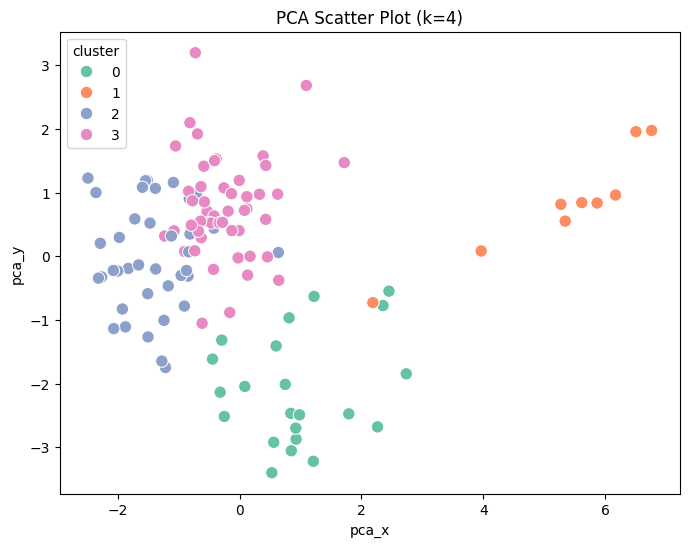

avg_comment_scraped  avg_danmaku  danmaku_missing_rate  \
cluster                                                           
0                  14.277273     5.895455              0.522727   
1                   2.761111     0.072222              0.933333   
2                  91.412536  1123.113675              0.008974   
3                  90.726319   787.118523              0.028604   

         comment_topic_diversity  danmaku_topic_diversity  comment_repetition  \
cluster                                                                         
0                       1.649942                 1.553164            0.402649   
1                       1.558907                 0.000000            0.714805   
2                       0.675253                 1.124923            0.385067   
3                       1.210980                 1.118198            0.418542   

         danmaku_repetition  comment_semantic_cohesion  \
cluster                                                  
0                  0.540666                   0.538984   
1                  1.000000                   0.686713   
2                  0.371977                   0.536034   
3                  0.455908                   0.588862   

         danmaku_semantic_cohesion  content_cohesion  
cluster                                               
0                         0.602598          0.648790  
1                         0.872249          0.732258  
2                         0.578966          0.612106  
3                         0.636280          0.727355

Saved: /content/drive/MyDrive/6893/raw/20251112_0011/final_up_profile_cluster_k4.csv


In [ ]:
# ======================================
# 🔰 PCA + KMeans 聚类（可调 k）
# ======================================

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns

RAW_DIR = Path("/content/drive/MyDrive/6893/raw/20251112_0011")

# ========= 1. Load Final Feature Table ==========
df = pd.read_csv(RAW_DIR / "final_up_profile_v2.csv", dtype={"uid": str})
print("Loaded:", df.shape)

# ========= 2. Select feature columns (你之前使用的版本) ==========
feature_cols = [
    "avg_comment_scraped",
    "avg_danmaku",
    "danmaku_missing_rate",
    "comment_topic_diversity",
    "danmaku_topic_diversity",
    "comment_repetition",
    "danmaku_repetition",
    "comment_semantic_cohesion",
    "danmaku_semantic_cohesion",
    "content_cohesion",
]

df_feat = df[feature_cols].fillna(0)

# ========= 3. 标准化 ==========
scaler = StandardScaler()
X = scaler.fit_transform(df_feat)

# ========= 4. PCA (keep 2D for visualization) ==========
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

df["pca_x"] = X_pca[:, 0]
df["pca_y"] = X_pca[:, 1]

print("PCA explained variance ratio:", pca.explained_variance_ratio_)

# ========= 5. KMeans 聚类（修改这里的 k） ==========
k = 4  # <<<<<<<<<< 你可以随便改：3,4,5,6...
km = KMeans(n_clusters=k, random_state=42)
df["cluster"] = km.fit_predict(X)

# silhouette score
sil = silhouette_score(X, df["cluster"])
print(f"\nSilhouette Score (k={k}): {sil:.4f}")

# ========= 6. Scatter Plot ==========
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x="pca_x",
    y="pca_y",
    hue="cluster",
    palette="Set2",
    s=80
)
plt.title(f"PCA Scatter Plot (k={k})")
plt.show()

# ========= 7. Show cluster summary (feature means per cluster) ==========
cluster_summary = df.groupby("cluster")[feature_cols].mean()
display(cluster_summary)

# ========= 8. Save ==========
out_path = RAW_DIR / f"final_up_profile_cluster_k{k}.csv"
df.to_csv(out_path, index=False, encoding="utf-8-sig")
print("Saved:", out_path)

In [ ]:
# ============================================
# 🔰 打印每个 cluster 的 UP 列表（清晰分组）
# ============================================

import pandas as pd
from pathlib import Path

RAW_DIR = Path("/content/drive/MyDrive/6893/raw/20251112_0011")

# 修改这里：你想看的 k 值
k = 4

df = pd.read_csv(RAW_DIR / f"final_up_profile_cluster_k{k}.csv", dtype={"uid": str})

print(f"Loaded final_up_profile_cluster_k{k}.csv:", df.shape)

# 只选部分关键列显示，避免太长
cols_to_show = [
    "uid", "up_name", "followers",
    "avg_play", "avg_comment_scraped",
    "avg_danmaku", "danmaku_missing_rate",
]

# 按 cluster 分组打印
for c in sorted(df["cluster"].unique()):
    print("\n" + "="*60)
    print(f"Cluster {c}")
    print("="*60)

    sub = df[df["cluster"] == c][cols_to_show]

    # 排序：默认按 followers 从大到小
    sub = sub.sort_values("followers", ascending=False)

    print(sub.to_string(index=False))
    print(f"\n>>> 共 {len(sub)} 个 UP\n")

Loaded final_up_profile_cluster_k7.csv: (121, 31)

Cluster 0
             uid      up_name  followers  avg_play  avg_comment_scraped  avg_danmaku  danmaku_missing_rate
      1369801844     普本生的求职指南     386374  46665.95                46.35         6.20                  0.30
       109606796         鹅姐职场     377674   3553.95                 4.75         6.15                  0.00
       386917389 AI编程布道者-金角大王     197607   6581.75                 7.25         1.20                  0.65
       549737999     张真源的松果仓库     158424   1530.60                 4.75         2.20                  0.40
       217107039  AI产品经理PMGao      84575  16322.85                21.80         4.15                  0.50
      1440478645        黑猫剪影-      28365  34106.95                 1.30         0.75                  0.80
3546911659264635       开源项目盘点      26788   4189.15                 5.95         0.25                  0.75
       504573481      房磊AI新发现      26553   9483.80                21.50         6.8

## Trial 2 互动模式+规模参数

Loaded: (121, 28)
PCA explained variance ratio: [0.26987123 0.15515557]

Silhouette Score (k=4): 0.1640


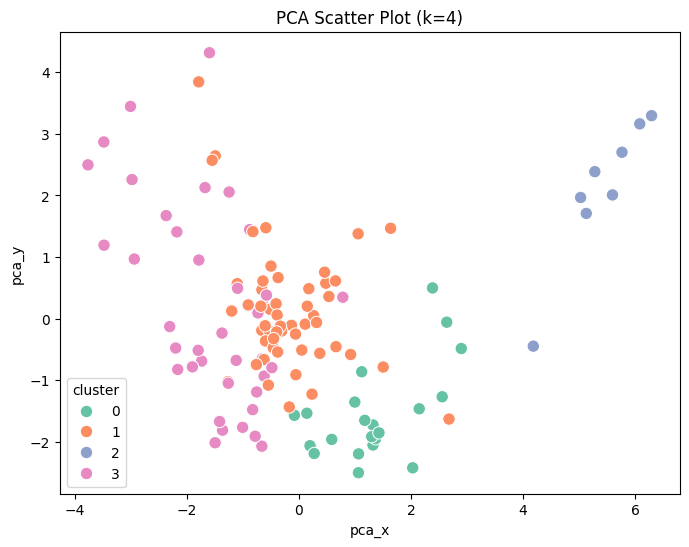

avg_comment_scraped  avg_danmaku  danmaku_missing_rate  \
cluster                                                           
0                  14.126190     5.766667              0.528571   
1                  87.374172   686.945811              0.054883   
2                   2.687500     0.081250              0.925000   
3                  91.848718  1219.101282              0.007692   

         comment_topic_diversity  danmaku_topic_diversity  comment_repetition  \
cluster                                                                         
0                       1.654878                 1.542040            0.400017   
1                       1.223389                 1.163964            0.421598   
2                       1.528099                 0.000000            0.729655   
3                       0.682228                 1.081045            0.386475   

         danmaku_repetition  comment_semantic_cohesion  \
cluster                                                  
0                  0.544934                   0.535584   
1                  0.434857                   0.588238   
2                  1.000000                   0.693877   
3                  0.399920                   0.538472   

         danmaku_semantic_cohesion  content_cohesion      avg_play  \
cluster                                                              
0                         0.606612          0.638128  2.102609e+04   
1                         0.622400          0.731199  4.529614e+05   
2                         0.872249          0.712810  6.686062e+02   
3                         0.594447          0.614724  1.217559e+06   

          avg_length  upload_freq     followers  
cluster                                          
0         703.026190    22.658580  9.142224e+04  
1        3577.977076     8.382470  1.642859e+06  
2         766.300000    14.181677  1.461562e+04  
3        1996.497436    15.118868  5.283352e+06

Saved: /content/drive/MyDrive/6893/raw/20251112_0011/final_up_profile_cluster_v2_k4.csv


In [ ]:
# ======================================
# 🔰 PCA + KMeans 聚类（可调 k）
# ======================================

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns

RAW_DIR = Path("/content/drive/MyDrive/6893/raw/20251112_0011")

# ========= 1. Load Final Feature Table ==========
df = pd.read_csv(RAW_DIR / "final_up_profile_v2.csv", dtype={"uid": str})
print("Loaded:", df.shape)

# ========= 2. Select feature columns (你之前使用的版本) ==========
feature_cols = [
    # 你原来的互动 & 文本特征
    "avg_comment_scraped",
    "avg_danmaku",
    "danmaku_missing_rate",
    "comment_topic_diversity",
    "danmaku_topic_diversity",
    "comment_repetition",
    "danmaku_repetition",
    "comment_semantic_cohesion",
    "danmaku_semantic_cohesion",
    "content_cohesion",

    # 新加的“规模 + 形态”
    "avg_play",
    "avg_length",
    "upload_freq",
    "followers"

    # 精简稳定性（选 1 个即可）
    # "cv_play",
    # "cv_length",
]

df_feat = df[feature_cols].fillna(0)

# ========= 3. 标准化 ==========
scaler = StandardScaler()
X = scaler.fit_transform(df_feat)

# ========= 4. PCA (keep 2D for visualization) ==========
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

df["pca_x"] = X_pca[:, 0]
df["pca_y"] = X_pca[:, 1]

print("PCA explained variance ratio:", pca.explained_variance_ratio_)

# ========= 5. KMeans 聚类（修改这里的 k） ==========
k = 4  # <<<<<<<<<< 你可以随便改：3,4,5,6...
km = KMeans(n_clusters=k, random_state=42)
df["cluster"] = km.fit_predict(X)

# silhouette score
sil = silhouette_score(X, df["cluster"])
print(f"\nSilhouette Score (k={k}): {sil:.4f}")

# ========= 6. Scatter Plot ==========
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x="pca_x",
    y="pca_y",
    hue="cluster",
    palette="Set2",
    s=80
)
plt.title(f"PCA Scatter Plot (k={k})")
plt.show()

# ========= 7. Show cluster summary (feature means per cluster) ==========
cluster_summary = df.groupby("cluster")[feature_cols].mean()
display(cluster_summary)

# ========= 8. Save ==========
out_path = RAW_DIR / f"final_up_profile_cluster_v2_k{k}.csv"
df.to_csv(out_path, index=False, encoding="utf-8-sig")
print("Saved:", out_path)

In [ ]:
# ============================================
# 🔰 打印每个 cluster 的 UP 列表（清晰分组）
# ============================================

import pandas as pd
from pathlib import Path

RAW_DIR = Path("/content/drive/MyDrive/6893/raw/20251112_0011")

# 修改这里：你想看的 k 值
k = 4

df = pd.read_csv(RAW_DIR / f"final_up_profile_cluster_v2_k{k}.csv", dtype={"uid": str})

print(f"Loaded final_up_profile_cluster_k{k}.csv:", df.shape)

# 只选部分关键列显示，避免太长
cols_to_show = [
    "uid", "up_name", "followers",
    "avg_play", "avg_comment_scraped",
    "avg_danmaku", "danmaku_missing_rate",
]

# 按 cluster 分组打印
for c in sorted(df["cluster"].unique()):
    print("\n" + "="*60)
    print(f"Cluster {c}")
    print("="*60)

    sub = df[df["cluster"] == c][cols_to_show]

    # 排序：默认按 followers 从大到小
    sub = sub.sort_values("followers", ascending=False)

    print(sub.to_string(index=False))
    print(f"\n>>> 共 {len(sub)} 个 UP\n")

Loaded final_up_profile_cluster_k4.csv: (121, 31)

Cluster 0
             uid      up_name  followers  avg_play  avg_comment_scraped  avg_danmaku  danmaku_missing_rate
       523995133         林粒粒呀     548067 283240.95                52.05        68.40                  0.20
      1369801844     普本生的求职指南     386374  46665.95                46.35         6.20                  0.30
       109606796         鹅姐职场     377674   3553.95                 4.75         6.15                  0.00
       386917389 AI编程布道者-金角大王     197607   6581.75                 7.25         1.20                  0.65
       549737999     张真源的松果仓库     158424   1530.60                 4.75         2.20                  0.40
       217107039  AI产品经理PMGao      84575  16322.85                21.80         4.15                  0.50
      1440478645        黑猫剪影-      28365  34106.95                 1.30         0.75                  0.80
3546911659264635       开源项目盘点      26788   4189.15                 5.95         0.2

## Trial 3 13维

Loaded: (121, 28)
PCA explained variance ratio: [0.30998456 0.15139525]

Silhouette Score (k=4): 0.3280


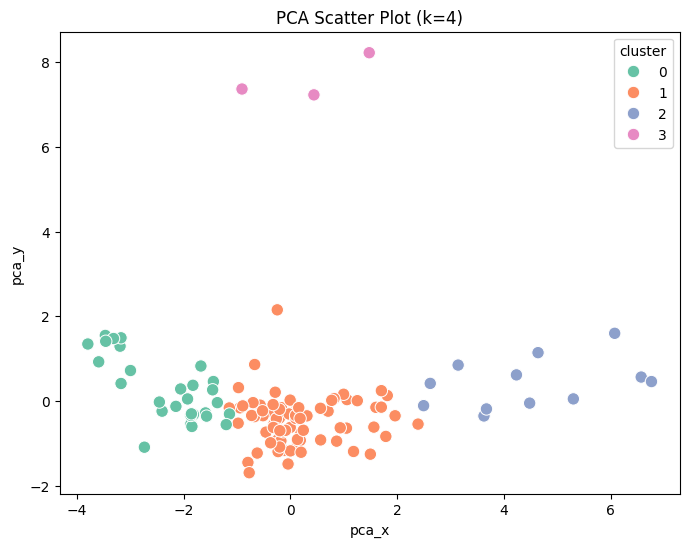

avg_length    std_length  upload_freq  comment_repetition  \
cluster                                                                
0          773.477586    565.543580    22.087162            0.501604   
1          840.188767    813.764707    11.691821            0.402917   
2         2546.066667   2393.622524     6.364446            0.387547   
3        56903.983333  58230.505692     2.006342            0.477700   

         danmaku_missing_rate  content_cohesion  comment_topic_diversity  \
cluster                                                                    
0                    0.668966          0.674385                 1.630595   
1                    0.028037          0.673230                 0.966959   
2                    0.004167          0.674770                 1.045062   
3                    0.033333          0.779292                 1.379983   

         danmaku_topic_diversity      avg_play  avg_danmaku      med_play  \
cluster                                                                     
0                       1.171640  4.231909e+03     1.922414  2.151638e+03   
1                       1.086866  4.318284e+05   498.072441  2.790364e+05   
2                       1.301620  2.926417e+06  3746.062500  2.470980e+06   
3                       1.375765  1.149383e+06   238.250000  1.458797e+05   

         avg_comment_scraped  med_danmaku  
cluster                                    
0                   8.294828     0.706897  
1                  88.886768   369.071429  
2                 100.508333  3695.458333  
3                  80.050000   101.833333

Saved: /content/drive/MyDrive/6893/raw/20251112_0011/final_cluster_k4.csv


In [ ]:
# ======================================
# 🔰 PCA + KMeans 聚类（可调 k）
# ======================================

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns

RAW_DIR = Path("/content/drive/MyDrive/6893/raw/20251112_0011")

# ========= 1. Load Final Feature Table ==========
df = pd.read_csv(RAW_DIR / "final_up_profile_v2.csv", dtype={"uid": str})
print("Loaded:", df.shape)

# ========= 2. Select feature columns (你之前使用的版本) ==========
feature_cols = [
    "avg_length",
    "std_length",
    "upload_freq",
    "comment_repetition",
    "danmaku_missing_rate",
    "content_cohesion",
    "comment_topic_diversity",
    "danmaku_topic_diversity",
    "avg_play",
    "avg_danmaku",
    "med_play",
    "avg_comment_scraped",
    "med_danmaku"
#     std_play
# med_play
# avg_comment_scraped
# med_comment_scraped
# med_danmaku
# avg_title_len
# avg_desc_len
]

df_feat = df[feature_cols].fillna(0)

# ========= 3. 标准化 ==========
scaler = StandardScaler()
X = scaler.fit_transform(df_feat)

# ========= 4. PCA (keep 2D for visualization) ==========
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

df["pca_x"] = X_pca[:, 0]
df["pca_y"] = X_pca[:, 1]

print("PCA explained variance ratio:", pca.explained_variance_ratio_)

# ========= 5. KMeans 聚类（修改这里的 k） ==========
k = 4  # <<<<<<<<<< 你可以随便改：3,4,5,6...
km = KMeans(n_clusters=k, random_state=42)
df["cluster"] = km.fit_predict(X)

# silhouette score
sil = silhouette_score(X, df["cluster"])
print(f"\nSilhouette Score (k={k}): {sil:.4f}")

# ========= 6. Scatter Plot ==========
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x="pca_x",
    y="pca_y",
    hue="cluster",
    palette="Set2",
    s=80
)
plt.title(f"PCA Scatter Plot (k={k})")
plt.show()

# ========= 7. Show cluster summary (feature means per cluster) ==========
cluster_summary = df.groupby("cluster")[feature_cols].mean()
display(cluster_summary)

# ========= 8. Save ==========
out_path = RAW_DIR / f"final_cluster_k{k}.csv"
df.to_csv(out_path, index=False, encoding="utf-8-sig")
print("Saved:", out_path)

In [ ]:
# ============================================
# 🔰 打印每个 cluster 的 UP 列表（清晰分组）
# ============================================

import pandas as pd
from pathlib import Path

RAW_DIR = Path("/content/drive/MyDrive/6893/raw/20251112_0011")

# 修改这里：你想看的 k 值
k = 4

df = pd.read_csv(RAW_DIR / f"final_cluster_k{k}.csv", dtype={"uid": str})

print(f"Loaded final_up_profile_cluster_k{k}.csv:", df.shape)

# 只选部分关键列显示，避免太长
cols_to_show = [
    "uid", "up_name", "followers",
    "avg_play", "avg_comment_scraped",
    "avg_danmaku", "danmaku_missing_rate",
]

# 按 cluster 分组打印
for c in sorted(df["cluster"].unique()):
    print("\n" + "="*60)
    print(f"Cluster {c}")
    print("="*60)

    sub = df[df["cluster"] == c][cols_to_show]

    # 排序：默认按 followers 从大到小
    sub = sub.sort_values("followers", ascending=False)

    print(sub.to_string(index=False))
    print(f"\n>>> 共 {len(sub)} 个 UP\n")

Loaded final_up_profile_cluster_k4.csv: (121, 31)

Cluster 0
             uid      up_name  followers  avg_play  avg_comment_scraped  avg_danmaku  danmaku_missing_rate
       383433896     教日语的阿飞老师    1275269   5068.20                17.45         8.60                  0.40
       109606796         鹅姐职场     377674   3553.95                 4.75         6.15                  0.00
       386917389 AI编程布道者-金角大王     197607   6581.75                 7.25         1.20                  0.65
       549737999     张真源的松果仓库     158424   1530.60                 4.75         2.20                  0.40
       217107039  AI产品经理PMGao      84575  16322.85                21.80         4.15                  0.50
       345880241      好奇代码的三木      41410   1004.65                 3.55         0.15                  0.90
      1440478645        黑猫剪影-      28365  34106.95                 1.30         0.75                  0.80
       479659041      懂设计的产品人      27297    286.20                 0.30         0.0

In [ ]:
df = pd.read_csv(RAW_DIR / "final_up_profile_v2.csv")
df.columns

Index(['uid', 'up_name', 'followers', 'n_videos', 'avg_play', 'med_play',
       'std_play', 'avg_comment_scraped', 'med_comment_scraped', 'avg_danmaku',
       'med_danmaku', 'avg_title_len', 'avg_desc_len', 'avg_length',
       'std_length', 'danmaku_missing_rate', 'upload_freq',
       'sentiment_mean_comment', 'sentiment_std_comment',
       'sentiment_mean_danmaku', 'sentiment_std_danmaku',
       'comment_topic_diversity', 'danmaku_topic_diversity',
       'content_cohesion', 'comment_repetition', 'danmaku_repetition',
       'comment_semantic_cohesion', 'danmaku_semantic_cohesion'],
      dtype='object')

## Trial 4 15维

Loaded: (121, 28)
PCA explained variance ratio: [0.34068785 0.19302985]

Silhouette Score (k=4): 0.3259


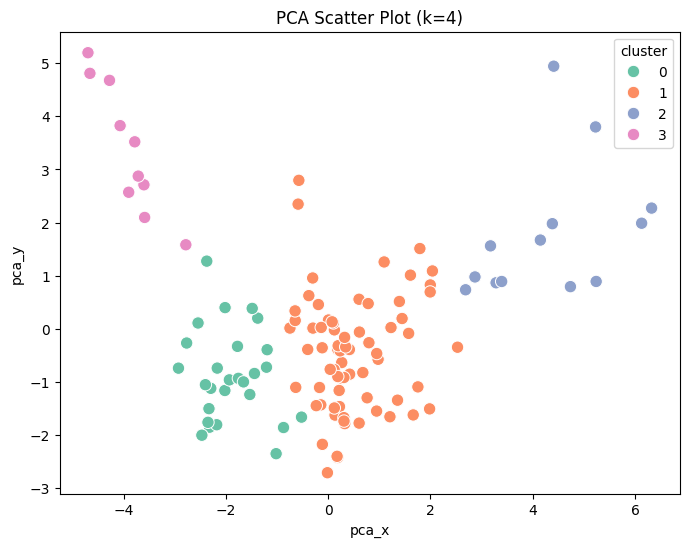

std_length   avg_length      avg_play      med_play      std_play  \
cluster                                                                       
0         828.357445   748.238671  3.080331e+04  1.006148e+04  6.294812e+04   
1        1945.373995  2656.837900  4.612571e+05  3.015715e+05  4.921966e+05   
2        9023.277008  5581.550000  2.950014e+06  2.303720e+06  2.627168e+06   
3         468.582789   699.205000  7.546750e+02  5.995000e+02  5.233071e+02   

         med_comment_scraped  avg_comment_scraped  sentiment_std_comment  \
cluster                                                                    
0                  14.907407            21.066885               0.265964   
1                  97.007042            93.589088               0.247345   
2                 100.961538            99.065385               0.238839   
3                   1.650000             2.960000               0.182845   

         comment_semantic_cohesion  danmaku_missing_rate  avg_danmaku  \
cluster                                                                 
0                         0.539185              0.441068    16.252832   
1                         0.566223              0.011972   538.576782   
2                         0.567529              0.011538  3491.861538   
3                         0.683765              0.880000     0.285000   

         med_danmaku  content_cohesion  comment_repetition  
cluster                                                     
0           6.351852          0.650018            0.397690  
1         400.894366          0.678973            0.407074  
2        3419.500000          0.674008            0.390351  
3           0.150000          0.731125            0.694039

Saved: /content/drive/MyDrive/6893/raw/20251112_0011/final_cluster_d15_k4.csv


In [ ]:
# ======================================
# 🔰 PCA + KMeans 聚类（可调 k）
# ======================================

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns

RAW_DIR = Path("/content/drive/MyDrive/6893/raw/20251112_0011")

# ========= 1. Load Final Feature Table ==========
df = pd.read_csv(RAW_DIR / "final_up_profile_v2.csv", dtype={"uid": str})
print("Loaded:", df.shape)

# ========= 2. Select feature columns (你之前使用的版本) ==========
feature_cols = [
    "std_length",
    "avg_length",

    "avg_play",
    "med_play",
    "std_play",

    "med_comment_scraped",
    "avg_comment_scraped",

    "sentiment_std_comment",
    "comment_semantic_cohesion",

    "danmaku_missing_rate",
    "avg_danmaku",
    "med_danmaku",

    "content_cohesion",
    "comment_repetition",

    # followers 不加入聚类，但可用于分析阶段标注 cluster 特性
]

df_feat = df[feature_cols].fillna(0)

# ========= 3. 标准化 ==========
scaler = StandardScaler()
X = scaler.fit_transform(df_feat)

# ========= 4. PCA (keep 2D for visualization) ==========
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

df["pca_x"] = X_pca[:, 0]
df["pca_y"] = X_pca[:, 1]

print("PCA explained variance ratio:", pca.explained_variance_ratio_)

# ========= 5. KMeans 聚类（修改这里的 k） ==========
k = 4  # <<<<<<<<<< 你可以随便改：3,4,5,6...
km = KMeans(n_clusters=k, random_state=42)
df["cluster"] = km.fit_predict(X)

# silhouette score
sil = silhouette_score(X, df["cluster"])
print(f"\nSilhouette Score (k={k}): {sil:.4f}")

# ========= 6. Scatter Plot ==========
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x="pca_x",
    y="pca_y",
    hue="cluster",
    palette="Set2",
    s=80
)
plt.title(f"PCA Scatter Plot (k={k})")
plt.show()

# ========= 7. Show cluster summary (feature means per cluster) ==========
cluster_summary = df.groupby("cluster")[feature_cols].mean()
display(cluster_summary)

# ========= 8. Save ==========
out_path = RAW_DIR / f"final_cluster_d15_k{k}.csv"
df.to_csv(out_path, index=False, encoding="utf-8-sig")
print("Saved:", out_path)

In [ ]:
# ============================================
# 🔰 打印每个 cluster 的 UP 列表（清晰分组）
# ============================================

import pandas as pd
from pathlib import Path

RAW_DIR = Path("/content/drive/MyDrive/6893/raw/20251112_0011")

# 修改这里：你想看的 k 值
k = 4

df = pd.read_csv(RAW_DIR / f"final_cluster_d15_k{k}.csv", dtype={"uid": str})

print(f"Loaded final_up_profile_cluster_k{k}.csv:", df.shape)

# 只选部分关键列显示，避免太长
cols_to_show = [
    "uid", "up_name", "followers",
    "avg_play", "avg_comment_scraped",
    "avg_danmaku", "danmaku_missing_rate",
]

# 按 cluster 分组打印
for c in sorted(df["cluster"].unique()):
    print("\n" + "="*60)
    print(f"Cluster {c}")
    print("="*60)

    sub = df[df["cluster"] == c][cols_to_show]

    # 排序：默认按 followers 从大到小
    sub = sub.sort_values("followers", ascending=False)

    print(sub.to_string(index=False))
    print(f"\n>>> 共 {len(sub)} 个 UP\n")

Loaded final_up_profile_cluster_k4.csv: (121, 31)

Cluster 0
             uid       up_name  followers      avg_play  avg_comment_scraped  avg_danmaku  danmaku_missing_rate
       400813602 Ayase-YOASOBI    1601566 176226.000000            51.150000   108.950000              0.500000
       232472043       DJI大疆创新    1396904  78257.450000            47.250000    53.100000              0.000000
       383433896      教日语的阿飞老师    1275269   5068.200000            17.450000     8.600000              0.400000
       679237565        张宇考研数学    1261276  22848.800000            51.250000    36.900000              0.250000
       523995133          林粒粒呀     548067 283240.950000            52.050000    68.400000              0.200000
      1369801844      普本生的求职指南     386374  46665.950000            46.350000     6.200000              0.300000
       109606796          鹅姐职场     377674   3553.950000             4.750000     6.150000              0.000000
       386917389  AI编程布道者-金角大王     197607  

## Trial 5 14维

Loaded: (121, 28)
PCA explained variance ratio: [0.32982663 0.15174848]

Silhouette Score (k=5): 0.3638


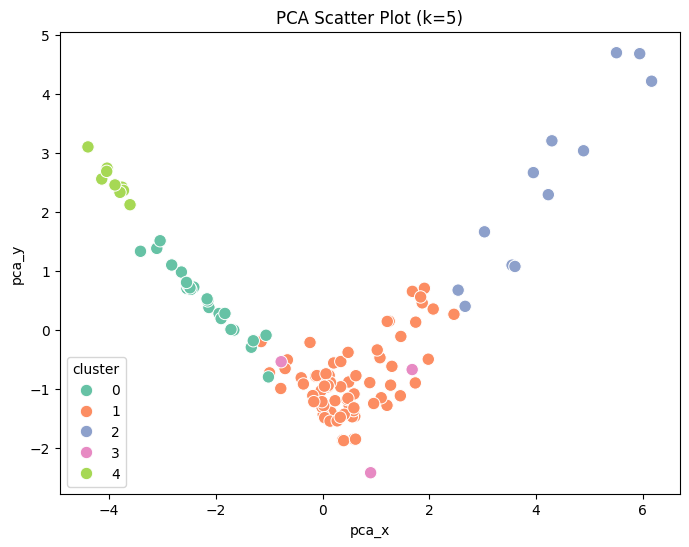

avg_length    std_length  upload_freq  comment_repetition  \
cluster                                                                
0          780.731765    815.572134    19.851257            0.401715   
1          845.817235    757.544438    12.290406            0.404097   
2         2546.066667   2393.622524     6.364446            0.387547   
3        56903.983333  58230.505692     2.006342            0.477700   
4          745.361111    458.682603    17.734140            0.714805   

         danmaku_missing_rate  content_cohesion  comment_topic_diversity  \
cluster                                                                    
0                    0.462353          0.649009                 1.613474   
1                    0.022222          0.674726                 0.935778   
2                    0.004167          0.674770                 1.045062   
3                    0.033333          0.779292                 1.379983   
4                    0.933333          0.732258                 1.558907   

         danmaku_topic_diversity      avg_play  avg_danmaku      med_play  \
cluster                                                                     
0                       1.534939  2.223551e+04     9.683059  6.753720e+03   
1                       1.068743  4.557168e+05   530.063910  2.968696e+05   
2                       1.301620  2.926417e+06  3746.062500  2.470980e+06   
3                       1.375765  1.149383e+06   238.250000  1.458797e+05   
4                       0.000000  6.684611e+02     0.072222  5.276111e+02   

         avg_comment_scraped  med_danmaku  med_comment_scraped  
cluster                                                         
0                  16.956235     5.960000            10.740000  
1                  92.167712   392.916667            95.236111  
2                 100.508333  3695.458333           101.000000  
3                  80.050000   101.833333            89.833333  
4                   2.761111     0.000000             1.333333

Saved: /content/drive/MyDrive/6893/raw/20251112_0011/final_cluster_d14_k5.csv


In [ ]:
# ======================================
# 🔰 PCA + KMeans 聚类（可调 k）
# ======================================

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns

RAW_DIR = Path("/content/drive/MyDrive/6893/raw/20251112_0011")

# ========= 1. Load Final Feature Table ==========
df = pd.read_csv(RAW_DIR / "final_up_profile_v2.csv", dtype={"uid": str})
print("Loaded:", df.shape)

# ========= 2. Select feature columns (你之前使用的版本) ==========
feature_cols = [
    "avg_length",
    "std_length",
    "upload_freq",
    "comment_repetition",
    "danmaku_missing_rate",
    "content_cohesion",
    "comment_topic_diversity",
    "danmaku_topic_diversity",
    "avg_play",
    "avg_danmaku",
    "med_play",
    "avg_comment_scraped",
    "med_danmaku",

    "med_comment_scraped"
#     std_play
# med_play
# avg_comment_scraped
# med_comment_scraped
# med_danmaku
# avg_title_len
# avg_desc_len
]

df_feat = df[feature_cols].fillna(0)

# ========= 3. 标准化 ==========
scaler = StandardScaler()
X = scaler.fit_transform(df_feat)

# ========= 4. PCA (keep 2D for visualization) ==========
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

df["pca_x"] = X_pca[:, 0]
df["pca_y"] = X_pca[:, 1]

print("PCA explained variance ratio:", pca.explained_variance_ratio_)

# ========= 5. KMeans 聚类（修改这里的 k） ==========
k = 5  # <<<<<<<<<< 你可以随便改：3,4,5,6...
km = KMeans(n_clusters=k, random_state=42)
df["cluster"] = km.fit_predict(X)

# silhouette score
sil = silhouette_score(X, df["cluster"])
print(f"\nSilhouette Score (k={k}): {sil:.4f}")

# ========= 6. Scatter Plot ==========
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x="pca_x",
    y="pca_y",
    hue="cluster",
    palette="Set2",
    s=80
)
plt.title(f"PCA Scatter Plot (k={k})")
plt.show()

# ========= 7. Show cluster summary (feature means per cluster) ==========
cluster_summary = df.groupby("cluster")[feature_cols].mean()
display(cluster_summary)

# ========= 8. Save ==========
out_path = RAW_DIR / f"final_cluster_d14_k{k}.csv"
df.to_csv(out_path, index=False, encoding="utf-8-sig")
print("Saved:", out_path)

In [ ]:
# ============================================
# 🔰 打印每个 cluster 的 UP 列表（清晰分组）
# ============================================

import pandas as pd
from pathlib import Path

RAW_DIR = Path("/content/drive/MyDrive/6893/raw/20251112_0011")

# 修改这里：你想看的 k 值
k = 5

df = pd.read_csv(RAW_DIR / f"final_cluster_d14_k{k}.csv", dtype={"uid": str})

print(f"final_cluster_d14_k{k}.csv:", df.shape)

# 只选部分关键列显示，避免太长
cols_to_show = [
    "uid", "up_name", "followers",
    "avg_play", "avg_comment_scraped",
    "avg_danmaku", "danmaku_missing_rate",
]

# 按 cluster 分组打印
for c in sorted(df["cluster"].unique()):
    print("\n" + "="*60)
    print(f"Cluster {c}")
    print("="*60)

    sub = df[df["cluster"] == c][cols_to_show]

    # 排序：默认按 followers 从大到小
    sub = sub.sort_values("followers", ascending=False)

    print(sub.to_string(index=False))
    print(f"\n>>> 共 {len(sub)} 个 UP\n")

final_cluster_d14_k5.csv: (121, 31)

Cluster 0
             uid      up_name  followers      avg_play  avg_comment_scraped  avg_danmaku  danmaku_missing_rate
       383433896     教日语的阿飞老师    1275269   5068.200000            17.450000     8.600000              0.400000
       523995133         林粒粒呀     548067 283240.950000            52.050000    68.400000              0.200000
      1369801844     普本生的求职指南     386374  46665.950000            46.350000     6.200000              0.300000
       109606796         鹅姐职场     377674   3553.950000             4.750000     6.150000              0.000000
       386917389 AI编程布道者-金角大王     197607   6581.750000             7.250000     1.200000              0.650000
          718918        熊妹撩电影     178259  72942.850000            35.150000    51.900000              0.000000
       549737999     张真源的松果仓库     158424   1530.600000             4.750000     2.200000              0.400000
       217107039  AI产品经理PMGao      84575  16322.850000           

# 寻找有效Features

In [ ]:
import pandas as pd
from pathlib import Path

RAW_DIR = Path("/content/drive/MyDrive/6893/raw/20251112_0011")
df = pd.read_csv(RAW_DIR / "final_up_profile_v2.csv")

# 打印完整列名
print("All columns:")
print(df.columns.tolist())

# 自动识别数值类型的特征列
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("\nNumeric feature candidates:")
print(numeric_cols)

All columns:
['uid', 'up_name', 'followers', 'n_videos', 'avg_play', 'med_play', 'std_play', 'avg_comment_scraped', 'med_comment_scraped', 'avg_danmaku', 'med_danmaku', 'avg_title_len', 'avg_desc_len', 'avg_length', 'std_length', 'danmaku_missing_rate', 'upload_freq', 'sentiment_mean_comment', 'sentiment_std_comment', 'sentiment_mean_danmaku', 'sentiment_std_danmaku', 'comment_topic_diversity', 'danmaku_topic_diversity', 'content_cohesion', 'comment_repetition', 'danmaku_repetition', 'comment_semantic_cohesion', 'danmaku_semantic_cohesion']

Numeric feature candidates:
['uid', 'followers', 'n_videos', 'avg_play', 'med_play', 'std_play', 'avg_comment_scraped', 'med_comment_scraped', 'avg_danmaku', 'med_danmaku', 'avg_title_len', 'avg_desc_len', 'avg_length', 'std_length', 'danmaku_missing_rate', 'upload_freq', 'sentiment_mean_comment', 'sentiment_std_comment', 'sentiment_mean_danmaku', 'sentiment_std_danmaku', 'comment_topic_diversity', 'danmaku_topic_diversity', 'content_cohesion', 'co

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 读取文件
RAW_DIR = Path("/content/drive/MyDrive/6893/raw/20251112_0011")
df = pd.read_csv(RAW_DIR / "final_up_profile_v2.csv")

# 所有有效特征
feature_pool = [
    "n_videos",
    "avg_play", "med_play", "std_play",
    "avg_comment_scraped", "med_comment_scraped",
    "avg_danmaku", "med_danmaku",

    "avg_title_len", "avg_desc_len",
    "avg_length", "std_length",

    "upload_freq",
    "danmaku_missing_rate",
    "content_cohesion",

    "comment_repetition", "danmaku_repetition",

    "comment_topic_diversity", "danmaku_topic_diversity",
    "comment_semantic_cohesion", "danmaku_semantic_cohesion",

    "sentiment_mean_comment", "sentiment_std_comment",
    "sentiment_mean_danmaku", "sentiment_std_danmaku",
    "followers"
]

X = df[feature_pool].fillna(0)
X_scaled = StandardScaler().fit_transform(X)

pca = PCA(n_components=4)
pca.fit(X_scaled)

importance = np.abs(pca.components_).sum(axis=0)
feature_scores = pd.Series(importance, index=feature_pool).sort_values(ascending=False)

print("=== Feature Importance Ranking (PCA Loading) ===")
print(feature_scores)
print("\nTop 15:")
print(feature_scores.head(15))

=== Feature Importance Ranking (PCA Loading) ===
std_length                   1.005316
avg_length                   0.915655
avg_play                     0.904626
med_play                     0.881253
std_play                     0.832427
med_comment_scraped          0.808531
sentiment_std_comment        0.798851
avg_comment_scraped          0.793864
comment_semantic_cohesion    0.791201
danmaku_missing_rate         0.778330
avg_danmaku                  0.745040
med_danmaku                  0.701060
content_cohesion             0.699305
followers                    0.669692
comment_repetition           0.631749
sentiment_mean_comment       0.618307
avg_title_len                0.587054
danmaku_repetition           0.557420
sentiment_std_danmaku        0.554921
danmaku_topic_diversity      0.542022
comment_topic_diversity      0.453545
sentiment_mean_danmaku       0.444732
upload_freq                  0.378459
avg_desc_len                 0.328311
danmaku_semantic_cohesion    0.262485
n

=== Testing combinations (size=3) ===


100%|██████████| 220/220 [00:01<00:00, 127.52it/s]


=== Testing combinations (size=4) ===


100%|██████████| 495/495 [00:03<00:00, 161.63it/s]


=== Testing combinations (size=5) ===


100%|██████████| 792/792 [00:04<00:00, 181.32it/s]


=== Testing combinations (size=6) ===


100%|██████████| 924/924 [00:05<00:00, 160.05it/s]


=== Testing combinations (size=7) ===


100%|██████████| 792/792 [00:04<00:00, 165.48it/s]


=== Testing combinations (size=8) ===


100%|██████████| 495/495 [00:02<00:00, 174.34it/s]


=== Testing combinations (size=9) ===


100%|██████████| 220/220 [00:01<00:00, 174.28it/s]


=== Testing combinations (size=10) ===


100%|██████████| 66/66 [00:00<00:00, 181.81it/s]



===== 🎖️ Top 20 Feature Combinations =====
Score=0.9312 | Features=('std_length', 'avg_length', 'upload_freq')
Score=0.8077 | Features=('std_length', 'avg_length', 'danmaku_missing_rate')
Score=0.7903 | Features=('std_length', 'avg_length', 'comment_repetition')
Score=0.7839 | Features=('avg_length', 'comment_repetition', 'upload_freq')
Score=0.7774 | Features=('std_length', 'sentiment_mean_danmaku', 'danmaku_semantic_cohesion', 'upload_freq')
Score=0.7763 | Features=('std_length', 'comment_repetition', 'upload_freq')
Score=0.7728 | Features=('avg_length', 'danmaku_missing_rate', 'upload_freq')
Score=0.7716 | Features=('std_length', 'avg_length', 'comment_repetition', 'upload_freq')
Score=0.7596 | Features=('std_length', 'danmaku_missing_rate', 'upload_freq')
Score=0.7532 | Features=('sentiment_mean_danmaku', 'avg_length', 'comment_repetition', 'upload_freq')
Score=0.7532 | Features=('std_length', 'avg_length', 'danmaku_missing_rate', 'upload_freq')
Score=0.7467 | Features=('std_lengt

feature  freq
0                upload_freq    37
1         comment_repetition    33
2                 avg_length    32
3                 std_length    31
4  danmaku_semantic_cohesion    24
5         danmaku_repetition    22
6     sentiment_mean_danmaku    20
7       danmaku_missing_rate     6
8     sentiment_mean_comment     1